# 1. Summary
The goal of this notebook is to produce a predictive probability distribution of where the football is likely to land for a punt play, that can be used both by the players of the receiving team in real time and as a metric for displaying on the broadcasting services before a punt play is about to start.
<br>
The final distribution looks like this:

$$\mathbf P(\alpha,\beta)\mathbf f(y; \mu_R, \sigma_R, 0, 53.3) + (1-\mathbf P(\alpha,\beta)) \mathbf f(y; \mu_L, \sigma_L, 0, 53.3)$$



Where

* $\mathbf P(\alpha, \beta) = \frac{\vert 2(\alpha-0.5)\vert \alpha+(1-\vert 2(\alpha-0.5)\vert )\beta+\vert 2(\beta-0.5)\vert \beta+(1-\vert 2(\beta-0.5)\vert )\alpha}{2} $ evaluates to the probability of the football being punted to the right as seen from the punter's perspective

* and $\mathbf f(y; \mu, \sigma, 0, 53.3)$ is a [truncated normal distribution ](https://en.wikipedia.org/wiki/Truncated_normal_distribution)

Which will be explained in detail as we go along.

<br>
All a player would have to do is to have four pre-calculated values in their head, while paying attention to the punter's position so it's not as difficult as it looks at first sight.

<br>
The model will produce images like these:


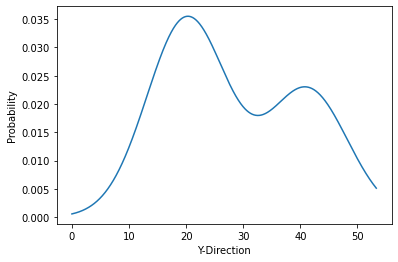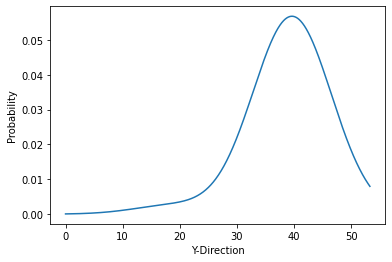

Which is the model's prediction for two of Bryan Anger's punts or as illustrated (very diligently) by my significant other:
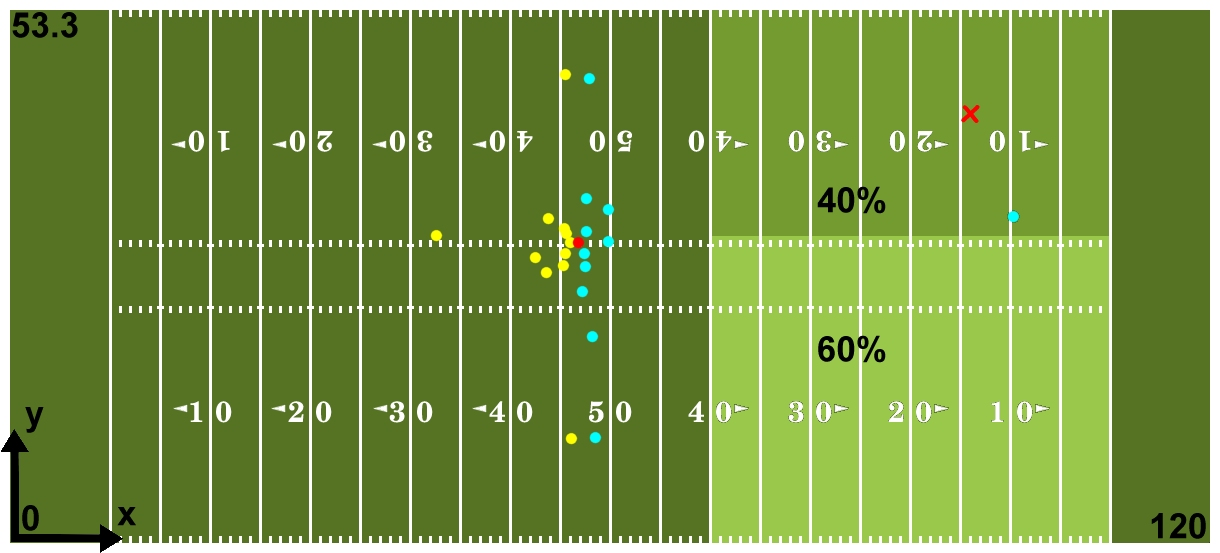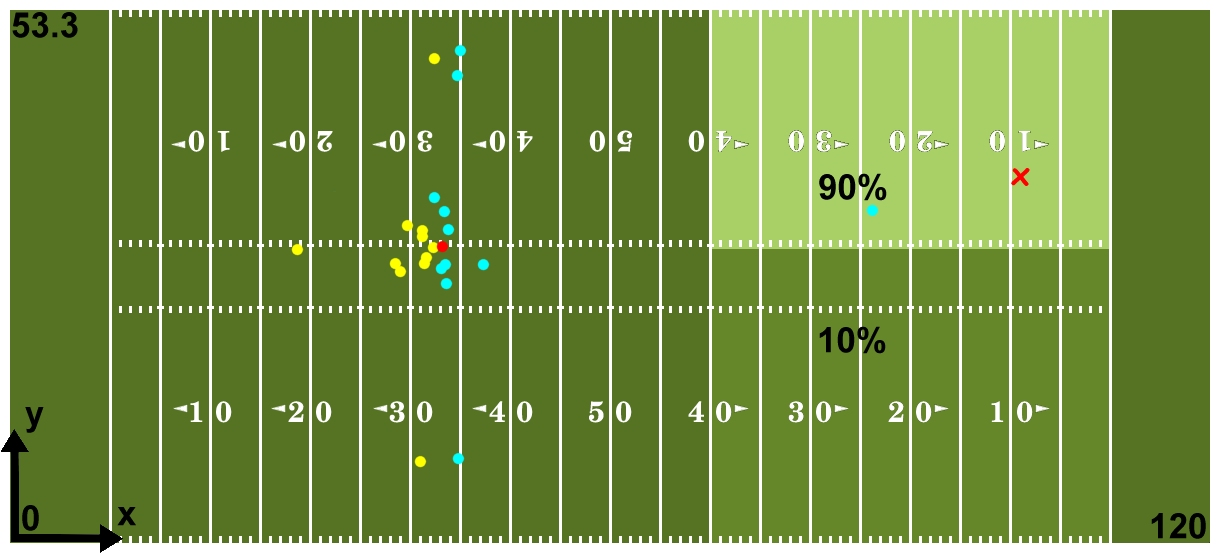
Where the red $X$ signifies the football's actual landing spot for the play.



# 2. Understanding the Data and What We Want to Achieve

As already pointed out in the summary our goal is a predictive model for where the football is likely to land. First and foremost, to *be* a predictive model, it's absolutely ***crucial*** that we only ever use data that has happened ***prior*** to the play in question.
But how do we find out what our model should depend on? Well, we have to just intensely stare at the data until we notice patterns specific to either the whole team, punters or anyone else. 
<br>

It could, for example, depend on the specific gunners, a team might like to punt more into the direction of one gunner than another, it could depend on the specific formation of both teams, the position of the gunners, the specific jammers might play a role, a team might like to avoid a particular opponent or prefer to punt to another opponent and also the number of jammers might be important.
<br>

All of these potential reason I will put into a category of **strategy**, and, as I've come to realize, trying build a model to figure out a team's strategy using any combination of those reasons is much less fruitful than using the **tendency** of the players. An intuitive reason is that, well, the reality is that teams do not want to be easily predictable and will change their strategy as soon as it becomes too obvious, and any model based on past data will not be able to react quickly enough to any sudden change in strategy.
<br>

Instead, what this model focuses on is the ***tendency*** of the punter, as this is something that turns out to be much more reliable, much more difficult for a punter to suddenly just change mid-season and much more predictive than any of the strategic reasons.
<br>

Let's look at a couple of examples from the 2018 season and see if we can identify what exactly the tendency of a punter is. More specifically, as it turns out, all our focus will be on the $y$-offset of the punter relative to the football's position, where we will always use the coordinate-system in the direction of the punting team.





In [ ]:
import pandas as pd

my_data2=pd.read_csv("../input/tendency-examples/Andy Lee.csv")
print(my_data2)

This is Andy Lee in the 2018 season where
* The first column is the date (year, month, day, hour and minute all concatenated)
* The second column is the $y$-offset (in yards) relative to the football at frame one (the start of the play), a positive value means he's standing to the right of the football and a negative means he's standing to the left of the fooball
* And the final column is which direction the football finally got punted towards as seen from the punter's intial frame point-of-view

Here we can see one of the most common tendencies of punters. They tend to stand in the opposite direction they're punting to, if they're standing to the right of the football they will tend to punt left and when they're standing to the left they will tend to punt right. But there's also ones who like to always stand to the right or to the left of the football, no matter which direction they will punt towards, and many who, at first sight, have no tendencies at all. If we actually stare at data like this long enough we will start to see something hidden from plain sight, which is also directly related to the $y$-offset and just as important, and that is ***whether they are standing to the right or to the left of their average punting-frame-one-position up to but not including the current play***. Before continuing, let's first define our main quantities we will use from now on, which will be the basis of our calculation of whether the football will be punted towards the left or right.

1. The First Tendency $\alpha$<br>
To calculate $\alpha$ we will go through each punt play of the punter in question over the entire season up to but not including the play we wish to predict and ask the question: Is the punter's current play's frame one $y$-offset positive? If yes, then we will look at all the past plays of the season where the $y$-offset is positive and calculate what fraction of these plays resulted in a punt to the right. And do the same if the $y$-offset is negative. (Not forgetting the [rule of succession](https://en.wikipedia.org/wiki/Rule_of_succession))

2. The Second Tendency $\beta$<br>
To calculate $\beta$ we will, again, go through each punt play of the punter in question over the entire season up to but not including the play we wish to predict and ask the question: Is the punter's current play's frame one $y$-offset positive or negative relative to their average $y$-offset? If yes, then we will look at all the past plays of the season where the $y$-offset is positive relative to the average $y$-offset at that time and calculate what fraction of these plays resulted in a punt to the right. And do the same if it is negative.  (Again, not forgetting the [rule of succession](https://en.wikipedia.org/wiki/Rule_of_succession))

$\alpha$ and $\beta$ go from $0$ to $1$ where values close to $0$ mean a low percentage of punts to the right, and values close to $1$ a high percentage of punts to the right.

Now, I have already mentioned that we only want to look at plays of the current season. Why wouldn't we take any information from the past season? Well as it turns out, while tendencies are very stable within a season, they can change dramatically between seasons. An intuitive reason is that during the season the punter's don't have the luxury to work on changing their muscle memory and try to change/improve their playstyle. That is something that happens in between-season where they have time to work on their fundamentals and evolve as an individual.

As an example of how tendencies can change between seasons we can compare Tress Way at beginning of $2018$


In [ ]:
import pandas as pd 

my_data3=pd.read_csv("../input/tendency-examples/Tress Way 2018.csv")
print(my_data3)

<p style="text-align:center;"> and $2019$ </p>

In [ ]:
import pandas as pd 

my_data3=pd.read_csv("../input/tendency-examples/Tress Way 2019.csv")
print(my_data3)

As we can see in $2018$ he mainly seems to follow the most common tendency, but then changed it up completely in $2019$, always standing to the right.

As an aside, also an interesting question is:
Should we consider any matches played in the pre-season?
<br>In the data given these matches are not included, but I would probably not base anything off of them anyway, since the teams don't have anything competitive to play for, so they will likely not play to their full potential extent.

Let's look at a straight-forward example of how the values $\alpha$ and $\beta$ might look like for a punter.

In [ ]:
import pandas as pd

my_data3=pd.read_csv("../input/matt-haack/Matt Haack 2019.csv")
print(my_data3)

This is the start of the $2019$ season for Matt Haack, $\alpha$ and $\beta$ move mostly in tandem, and as the season progresses the tendencies start to become apparent and will generally stay so for the rest of the season.

Let's look at someone else, like Bryan Anger, as he is one of the more illusive punters in the mix, and those are the ones we should focus our attention on to pick up on possible improvements for our model and how to finally quantify things.

In [ ]:
import pandas as pd

my_data3=pd.read_csv("../input/tendency-examples/Bryan Anger.csv")
print(my_data3)

This is late in the season of $2019$ and as we can see we don't gain much information from $\alpha$, because it is close to $50\%$, but $\beta$ comes to the rescue as it gives much more decisive answers. In fact we should give most if not all our attention to $\beta$ in this case and it is generally so, when one looks at more player examples, that we should shift our attention very sharply to the values which are furthest from $50\%$, this gives us a huge hint in how to use $\alpha$ and $\beta$ quantitatively for our model.

# 3. Quantifying the Model

## 3.1 Direction of a Punt

At the end we want to arrive at a probability distribution where the football lands, but before that, we need to first decide whether the football will be punted to the left or right.
Following the hint from the last section, what we want is some function involing $\alpha$ and $\beta$ which shifts it's weight sharply to the quantity which is furthest away from $50\%$.
The following [absolute value](https://en.wikipedia.org/wiki/Absolute_value/) function is just what we are looking for:
<br>
$$F(x) = \vert 2(x-0.5)\vert $$
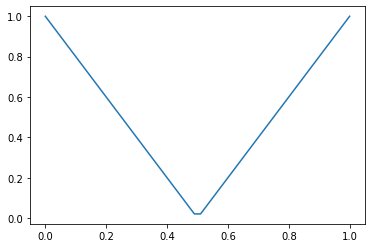


One can play around with other functions and slopes like the absolute value of a logistic function shifted the same way, but I've found that this simple function turns out to perform the best.

So our formula for calculating the probability of the punt going to the right might look like this:

$\vert 2(\alpha-0.5)\vert \alpha+(1-\vert 2(\alpha-0.5)\vert )\beta$

Which has the properties we are looking for. When $\alpha$ is close to $0.5$ we shift all our attention to $\beta$, and when $\alpha$ is close to $0$ or $1$ we shift it towards $\alpha$.
<br> There is no reason not to also consider the same function but with $\alpha$ and $\beta$ swapping places:

$\vert 2(\beta-0.5)\vert \beta+(1-\vert 2(\beta-0.5)\vert )\alpha$

Which possesses the same properties we are looking for and a priori there is no reason to prefer one over the other, so one has to [compare their performance](#Performance), and, as it turns out, the *average* of these functions performs better than any one individually.

So, finally, we arrive at the formula $$\mathbf P(\alpha,\beta) = \frac{\vert 2(\alpha-0.5)\vert \alpha+(1-\vert 2(\alpha-0.5)\vert )\beta+\vert 2(\beta-0.5)\vert \beta+(1-\vert 2(\beta-0.5)\vert )\alpha}{2} $$

which gives us the probability of the football being punted to the right.<br>
Let's [compare the model with the actual results](#ScatterPlots) to see how well it fits the data.

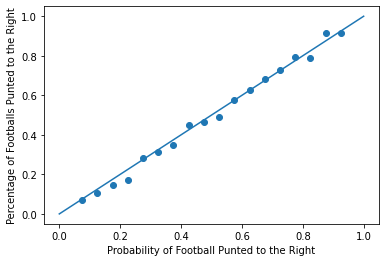

So it fits very well.

## 3.2 Length of a Punt

### 3.2.1 Horizontal Length

One can think of many things this may depend on... One thing it certainly depends on is the specific punter, so we can't just mix punt lengths of different punters and teams, because punters and teams tend to differ in how far they like to veer off to the right or left. A couple of things to note are:
* how far the punt play is in the $x$-direction of the field
* the $y$-offset of the football from the middle at the beginning of the play
* maybe if the tendency is more pronounced the further the punt is going to be
* difference in punting between the left and right direction

I have tried incorporating all of these things, and many more, the main thing that is important here, is that the earlier the field position is the narrower the punts tend to be. [A good approach](#Performance2) is roughly separating the field into three regions
* $x<20$
* $20<x<40$
* $x>40$

And taking the average punt length of the punter so far in the season within this region.

### 3.2.2 Vertical Length

The impression I get here is that punters try to punt the football as far as possible while also having the longest hangtime possible, so the football will land as close to the outer edge of the field in the $x$-direction as is possible without it being a touchback. This will mainly depend on how far the punt play is in the $x$-direction of the field and how far the punter can punt the football.<br> Anyway, I think, because it's very straight-forward that the football will tend to land somewhere near the outer edges, this is not very exciting. But for completeness sake I have dedicated [a section in the Appendix](#heatmap) to this where we will produce heat maps for where the ball is likely to land.

## 3.3 Putting the Pieces Together to Arrive at Our Final Model

So we got the direction and the length down, what should our probability distribution be? The natural choice is using normal distributions truncated at the edges of the field, and, testing and discarding many different options, that is also what performs the best.

$$\mathbf P(\alpha,\beta)\mathbf f(y; \mu_R, \sigma_R, 0, 53.3) + (1-\mathbf P(\alpha,\beta)) \mathbf f(y; \mu_L, \sigma_L, 0, 53.3)$$

Where $\mathbf f(y; \mu, \sigma, 0, 53.3)$ is a [truncated normal distribution ](https://en.wikipedia.org/wiki/Truncated_normal_distribution).

$\sigma_R$ and $\sigma_L$ could be estimated individually for each play but in reality they are simply *unknown*, $\sigma \approx \frac{2}{3} L$ works well, where $L$ is the expected punt length in the $y$-direction.



# 4. Conclusion and Caveats

As already pointed out, a player on the field can already have all four permutations of $P(\alpha,\beta)$ and the expected punt length pre-calculated in their head and ready to go based on where the punter stands. But, because I have never played football either professionally or casually in my life, I just can't tell whether knowing where the football is likely to go is something that is worth it for a player to have on their mind, or if trusting their intuition and focusing solely on the immediate moment is better. I am in no position to judge that.

What I can say though, is that it takes only one person on the receiving team, ideally someone who doesn't have to worry about what their direct opposite is about to do to and has a unobstructed view of the punter, to pay attention to the punter's position, and somehow communicate to the rest of the team where the punt is likely to land, as the punter settles down at his position.

Now let's say teams decide that this is something they want to do. What if the punter suddenly changes his tendencies? Judging from the years of data looked at, and how clear cut most punters' tendencies are with this model, this must be something that is very difficult to do on the fly and would likely go at the expense of the punter's performance. We can philosophize though, that this is something that catches on in a couple of years and gives teams, who are paying close attention, a big advantage. In between seasons a punter might then actually start to train two polar opposite tendencies, which would still probably result in a total loss of performance of the punter, but at that point the model becomes as obsolete as trying to predict the strategy based on past data. It would just not be able to react quickly enough to the sudden changes and after some time just settle down at $50\%$ to the left and $50\%$ to the right.

The use of this as a metric is up to the people at the NFL, but I would suggest a live overlay of the probability distribution, maybe split into two, three or four areas at the far end of the field as the punter and center start settling at their preferred positions. Or whatever else improves viewability to make the viewers more excited about what's going to happen. One would only need to have live access to the tracking data and use the formulas as I have described them here (see Appendix for details).
<hr>

# 5. Appendix

Here I describe how exactly I used the data to get to the results, please excuse any inefficient or bad looking code as my background lies more in physics than in anything directly coding related.

 ## 5.1 Bringing the Data into a Format I Am More Comfortable Working with

In [ ]:
#import csv
#import os
#
#os.chdir("directory of tracking csv")
## what I do here is reduce the amount of columns to the amount I need so that bringing the data into my preferred format doesn't take so long
#
## This reduces the csv-file to only include rows which have either the first frame in the column "frames" or have an event that is not None in the column "event"
#with open('tracking2018.csv', 'rt') as inp, open('tracking2018klein.csv', 'w', newline='') as out:
#    writer = csv.writer(out)
#    next(inp)
#    for row in csv.reader(inp):
#        if int(row[14]) == 1:
#            writer.writerow(row)
#    inp.seek(0)
#    next(inp)
#    for row in csv.reader(inp):
#        if row[8] != "None":
#            writer.writerow(row)
## This reduces the rows so that it only includes rows where it's about the football
#with open('tracking2018.csv', 'rt') as inp, open('tracking2018klein2.csv', 'w', newline='') as out:
#    writer = csv.writer(out)
#    next(inp)
#    for row in csv.reader(inp):
#        if row[10] == "football":
#            writer.writerow(row)
#            

In [ ]:
#import csv
#import os
#import pickle
#
#os.chdir("directory of tracking csv")
#dictionary = {}
#
## this gives me a nested dictionary of the form {'punter name': {gameid: {'all the punting playids of the gameid seperated by a space'}}
## and another dictionary, with all the punter's names which will be used as a basis for our final dictionary
#with open('tracking2018klein.csv') as f:
#    reader = csv.reader(f)
#    j = 0
#    for row in reader:
#        if row[12] == "P" and int(row[14]) == 1:
#            if row[10] not in dictionary:
#                dictionary[row[10]] = {}
#            if row[15] not in dictionary[row[10]]:
#                dictionary[row[10]][row[15]] = row[16]
#                continue
#            dictionary[row[10]][row[15]] += " " + row[16]
#    dictionary2 = {}
#    for j in dictionary:
#        if j not in dictionary2:
#            dictionary2[j] = {}
## this brings it to the final format I'm used to working with
#with open('tracking2018klein.csv') as f:
#    reader = csv.reader(f)
#    for j in dictionary:
#        for k in dictionary[j]:
#            for s in dictionary[j][k].split(" "):
#                f.seek(0)
#                for row in reader:
#                    if int(row[14]) == 1 and row[15] == k and row[16] == s:
## adds all the dates and all the player position's at frame 1 and whatever else might be useful to the final dictionary
#                        date = row[0].split("-")[0] + row[0].split("-")[1] + row[0].split("-")[2][0:2] + row[0].split("T")[1].split(":")[0] + row[0].split("T")[1].split(":")[1]
#                        if date not in dictionary2[j]:
#                            dictionary2[j][date] = {}
#                        dictionary2[j][date][row[10]] = {"position": row[12], "initialframe": 1, "x": row[1], "y": row[2], "o": row[6], "team": row[13], "gameid": row[15], "playid": row[16]}
## adds all the position of the football when there is an event to the final dictionary
#                    if row[15] == k and row[16] == s and row[8] != "None" and row[10] == "football":
#                        dictionary2[j][date][row[10]][row[8] + "frame"] = row[14]
#                        dictionary2[j][date][row[10]][row[8] + "positionx"] = row[1]
#                        dictionary2[j][date][row[10]][row[8] + "positiony"] = row[2]
#
#
## The final format of the dictionary looks something like
## {'Sam Koch':{'201912291809': {'Sam Acho': {'position': 'OLB', 'initialframe': 1, 'x': '24.5', 'y': '33.13', 'o': '53.68', 'team': 'home', 'gameid': '2019122912', 'playid': '281'},
##                              football': {'position': 'NA', 'initialframe': 1, 'x': '25.01', 'y': '30', 'o': 'NA', 'team': 'football', 'gameid': '2019122912', 'playid': '281', 'ball_snapframe': '11', 'ball_snappositionx': '25.03', 'ball_snappositiony': '30', 'extra_point_attemptframe': '26', 'extra_point_attemptpositionx': '27.35', 'extra_point_attemptpositiony': '29.36', 'extra_pointframe': '46', 'extra_pointpositionx': '-3.22', 'extra_pointpositiony': '25.41'}}
##                              etc.
#f = open("NFLlist2018.pckl", 'wb')
#pickle.dump(dictionary2, f)
#f.close()

In [ ]:
#import csv
#import os
#import pickle
#os.chdir("directory of tracking csv")
#f = open('NFLlist2018.pckl', 'rb')
#dictionary = pickle.load(f)
#f.close()
## The only thing that I need now is the frame at which the football lands
## Thanks to Thompson Bliss for pointing me toward using the hangtime for getting those coordinates
## This adds the football landing frame to my dictionary 
#with open('PFFScoutingData.csv') as f:
#    reader = csv.reader(f)
#    for s in dictionary:
#          for k in dictionary[s]:
#              f.seek(0)
#              for row in reader:
#                    if dictionary[s][k]['football']['gameid'] == row[0] and dictionary[s][k]['football']['playid'] == row[1] and row[5] != "NA":
#                        try:
#                            dictionary[s][k]['football']['puntpositionx']
#                        except KeyError:
#                            continue
#                        dictionary[s][k]['football']['football_landing_position_frame'] = int(round(float(row[5]), 1) * 10) + int(dictionary[s][k]['football']['puntframe'])
#
## This adds the position of the football when it lands to the dictionary
#with open('tracking2018klein2.csv') as f:
#    reader = csv.reader(f)
#    next(reader)
#    for row in reader:
#        for s in dictionary:
#            for k in dictionary[s]:
#                try:
#                    dictionary[s][k]['football']['football_landing_position_frame']
#                except KeyError:
#                    continue
#                if int(row[14]) == dictionary[s][k]['football']['football_landing_position_frame'] and row[15] ==  dictionary[s][k]['football']['gameid'] and  row[16] ==  dictionary[s][k]['football']['playid']:
#                    dictionary[s][k]['football']['football_landing_position_x'] = row[1]
#                    dictionary[s][k]['football']['football_landing_position_y'] = row[2]
#                    
#f = open("NFLlist2018.pckl", 'wb')
#pickle.dump(dictionary, f)
#f.close()


On my computer that takes roughly four hours for each season, but it has to be done only once and brings it, finally, to the format i'm used to working with.

A nested dictionary of the form
<br>
{"Punter's Name": {"Date of a play": {"All the players of both teams and the football for the play at hand":{"A bunch of things like the position at frame 1, the spot at which the football lands, gameid, playid, events and whatever else I think could be useful for the problem at hand"}}}}
<br>

Note that the date of a play is concatenated like "year"+"month"+"day"+"hour"+"minute" which makes it such that a play with a later date always has a higher integer value than a play with an earlier date.

<div id="ScatterPlots">
    
## 5.2 Producing the Scatter Plot

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

list_comparison = []
list_counter = []

for z in range(1, 19):
    times_ball_went_to_the_right = 0
    times_ball_went_to_the_left = 0
    for number in range(18,21):
        f = open('../input/nfldictionaries/NFLlist20' + str(number) + '.pckl', 'rb')
        dictionary = pickle.load(f)
        f.close()
        for name in dictionary:

            for date in dictionary[name]:
                #  Identifies if the play is a punt play
                try:
                    dictionary[name][date]["football"]["puntpositionx"]
                    dictionary[name][date]["football"]["ball_snappositionx"]
                except KeyError:
                    continue
                try:
                    dictionary[name][date]["football"]["punt_blockedpositionx"]
                    continue
                except KeyError:
                    pass
                try:
                    dictionary[name][date]["football"]['football_landing_position_y']
                except KeyError:
                    continue
                #  This is a coordinate transformation of all the relevant quantities to the direction of play of the punter
                if float(dictionary[name][date]["football"]['x']) - float(dictionary[name][date][name]["x"]) > 0:
                    football_y = float(dictionary[name][date]["football"]['y'])
                    punter_y = float(dictionary[name][date][name]["y"])
                    punter_x = float(dictionary[name][date][name]["x"])
                    puntresult_y = float(dictionary[name][date]["football"]["football_landing_position_y"])
                elif float(dictionary[name][date]["football"]['x']) - float(dictionary[name][date][name]["x"]) <= 0:
                    football_y = 53.3 - float(dictionary[name][date]["football"]['y'])
                    punter_y = 53.3 - float(dictionary[name][date][name]["y"])
                    punter_x = 120 - float(dictionary[name][date][name]["x"])
                    puntresult_y = 53.3 - float(dictionary[name][date]["football"]["football_landing_position_y"])
                past_y_offset = 0
                past_y_offset_counter = 0

                alpha_amount_of_times_ball_went_right_positive_offset = 0
                alpha_amount_of_times_ball_went_left_positive_offset = 0
                alpha_amount_of_times_ball_went_right_negative_offset = 0
                alpha_amount_of_times_ball_went_left_negative_offset = 0

                beta_amount_of_times_ball_went_right_positive_offset = 0
                beta_amount_of_times_ball_went_left_positive_offset = 0
                beta_amount_of_times_ball_went_right_negative_offset = 0
                beta_amount_of_times_ball_went_left_negative_offset = 0

                average_punt_length = 0
                average_punt_length_counter = 0
                early_region = 0
                early_region_counter = 0
                mid_region = 0
                mid_region_counter = 0
                late_region = 0
                late_region_counter = 0
                for past_date in dictionary[name]:
                    # This goes through all the plays that happened BEFORE the current play's date
                    if int(past_date) >= int(date):
                        continue

                    try:
                        dictionary[name][past_date]["football"]["puntpositionx"]
                        dictionary[name][past_date]["football"]["ball_snappositionx"]
                    except KeyError:
                        continue
                    try:
                        dictionary[name][past_date]["football"]["punt_blockedpositionx"]
                        continue
                    except KeyError:
                        pass
                    try:
                        dictionary[name][past_date]["football"]['football_landing_position_y']
                    except KeyError:
                        continue
                    if float(dictionary[name][past_date]["football"]['x']) - float(dictionary[name][past_date][name]["x"]) > 0:
                        past_football_y = float(dictionary[name][past_date]["football"]['y'])
                        past_punter_y = float(dictionary[name][past_date][name]["y"])
                        past_punter_x = float(dictionary[name][past_date][name]["x"])
                        past_puntresult_y = float(dictionary[name][past_date]["football"]["football_landing_position_y"])
                    elif float(dictionary[name][past_date]["football"]['x']) - float(dictionary[name][past_date][name]["x"]) <= 0:
                        past_football_y = 53.3 - float(dictionary[name][past_date]["football"]['y'])
                        past_punter_y = 53.3 - float(dictionary[name][past_date][name]["y"])
                        past_punter_x = 120 - float(dictionary[name][past_date][name]["x"])
                        past_puntresult_y = 53.3 - float(dictionary[name][past_date]["football"]["football_landing_position_y"])

                    past_y_offset_punter = past_football_y-past_punter_y  # Gives the y-offset of the punter to the ball, positive value means he's standing to the right, and negative to the left

                    past_y_offset_puntresult = past_punter_y-past_puntresult_y  # Gives the y-offset of the ball when it finally lands relative to the punter's frame 1 position

                    past_y_offset += past_y_offset_punter  # Counts up the y-offset of the punter to the ball for each past play

                    past_y_offset_counter += 1  # Together with past_y_offset gives us the average y-offset of the punter relative to the ball by division

                    further_past_average_position = 0
                    further_past_average_position_counter = 0
                    for further_past_date in dictionary[name]:
                        # This goes through all the past game of the past game and calculates the average y-offset relative to the ball up until that point in time
                        if int(further_past_date) >= int(past_date):
                            continue

                        try:
                            dictionary[name][further_past_date]["football"]["puntpositionx"]
                            dictionary[name][further_past_date]["football"]["ball_snappositionx"]
                        except KeyError:
                            continue
                        try:
                            dictionary[name][further_past_date]["football"]["punt_blockedpositionx"]
                            continue
                        except KeyError:
                            pass
                        try:
                            dictionary[name][further_past_date]["football"]['football_landing_position_y']
                        except KeyError:
                            continue
                        if float(dictionary[name][further_past_date]["football"]['x']) - float(dictionary[name][further_past_date][name]["x"]) > 0:
                            further_past_football_y = float(dictionary[name][further_past_date]["football"]['y'])
                            further_past_punter_y = float(dictionary[name][further_past_date][name]["y"])
                            further_past_puntresult_y = float(dictionary[name][further_past_date]["football"]["football_landing_position_y"])
                        elif float(dictionary[name][further_past_date]["football"]['x']) - float(dictionary[name][further_past_date][name]["x"]) <= 0:
                            further_past_football_y = 53.3 - float(dictionary[name][further_past_date]["football"]['y'])
                            further_past_punter_y = 53.3 - float(dictionary[name][further_past_date][name]["y"])
                            further_past_puntresult_y = 53.3 - float(dictionary[name][further_past_date]["football"]["football_landing_position_y"])

                        further_past_average_position += further_past_football_y-further_past_punter_y  # Counts up the y-offset of the punter to the ball for each further past play
                        further_past_average_position_counter += 1   # Together with further_past_average_position gives us the average y-offset of the punter relative to the ball for the past play by division

                    # This goes towards calculating alpha
                    if past_y_offset_punter > 0:
                        if past_y_offset_puntresult > 0:
                            alpha_amount_of_times_ball_went_right_positive_offset += 1
                        elif past_y_offset_puntresult < 0:
                            alpha_amount_of_times_ball_went_left_positive_offset += 1
                    elif past_y_offset_punter < 0:
                        if past_y_offset_puntresult > 0:
                            alpha_amount_of_times_ball_went_right_negative_offset += 1
                        if past_y_offset_puntresult < 0:
                            alpha_amount_of_times_ball_went_left_negative_offset += 1

                    # This goes towards calculating beta
                    try:
                        if further_past_average_position/further_past_average_position_counter > past_y_offset_punter:
                            if past_y_offset_puntresult > 0:
                                beta_amount_of_times_ball_went_right_positive_offset += 1
                            elif past_y_offset_puntresult < 0:
                                beta_amount_of_times_ball_went_left_positive_offset += 1
                        elif further_past_average_position/further_past_average_position_counter < past_y_offset_punter:
                            if past_y_offset_puntresult > 0:
                                beta_amount_of_times_ball_went_right_negative_offset += 1
                            if past_y_offset_puntresult < 0:
                                beta_amount_of_times_ball_went_left_negative_offset += 1
                    except ZeroDivisionError:
                        pass
                    # This goes towards calculating the expected puntlength
                    if past_punter_x <= 20:
                        early_region += abs(past_punter_y - past_puntresult_y)
                        early_region_counter += 1
                    elif past_punter_x > 20 and past_punter_x <= 40:
                        mid_region += abs(past_punter_y - past_puntresult_y)
                        mid_region_counter += 1
                    elif past_punter_x > 40:
                        late_region += abs(past_punter_y - past_puntresult_y)
                        late_region_counter += 1
                    average_punt_length += abs(past_punter_y-past_puntresult_y)
                    average_punt_length_counter += 1

                try:
                    punt_length = average_punt_length / average_punt_length_counter  # Expected value of the punt length in the y-direction with the punter's initial-frame position as the 0 coordinate
                except ZeroDivisionError:
                    continue
                current_y_offset = football_y - punter_y  # Current frame 1 y-offset of punter relative to the ball 
                past_y_offset = past_y_offset / past_y_offset_counter  # Average y-offset up until now

                # alpha
                alpha_positive = (alpha_amount_of_times_ball_went_right_positive_offset + 1) / (alpha_amount_of_times_ball_went_left_positive_offset + alpha_amount_of_times_ball_went_right_positive_offset + 2)
                alpha_negative = (alpha_amount_of_times_ball_went_right_negative_offset + 1) / (alpha_amount_of_times_ball_went_left_negative_offset + alpha_amount_of_times_ball_went_right_negative_offset + 2)
                # beta
                beta_positive = (beta_amount_of_times_ball_went_right_positive_offset + 1) / (beta_amount_of_times_ball_went_left_positive_offset + beta_amount_of_times_ball_went_right_positive_offset + 2)
                beta_negative = (beta_amount_of_times_ball_went_right_negative_offset + 1) / (beta_amount_of_times_ball_went_left_negative_offset + beta_amount_of_times_ball_went_right_negative_offset + 2)

                # This gives us the Probability of the ball being punted to the right from the punter's inital-frame position
                if current_y_offset > 0:
                    try:
                        if past_y_offset > current_y_offset:
                            prob_ball_goes_right = (abs(2 * (alpha_positive - 0.5)) * alpha_positive+(1 - abs(2 * (alpha_positive - 0.5))) * beta_positive + abs(2 * (beta_positive - 0.5)) * beta_positive + (1 - abs(2 * (beta_positive - 0.5))) * alpha_positive) / 2

                        elif past_y_offset < current_y_offset:
                            prob_ball_goes_right = (abs(2 * (alpha_positive - 0.5)) * alpha_positive + (1 - abs(2 * (alpha_positive - 0.5))) * beta_negative + abs(2 * (beta_negative - 0.5)) * beta_negative + (1 - abs(2 * (beta_negative - 0.5))) * alpha_positive) / 2
                    except ZeroDivisionError:
                        continue
                elif current_y_offset < 0:
                    try:
                        if past_y_offset > current_y_offset:
                            prob_ball_goes_right = (abs(2 * (alpha_negative - 0.5)) * alpha_negative + (1 - abs(2 * (alpha_negative - 0.5))) * beta_positive + abs(2 * (beta_positive - 0.5)) * beta_positive + (1-abs(2 * (beta_positive - 0.5))) * alpha_negative) / 2

                        elif past_y_offset < current_y_offset:
                            prob_ball_goes_right = (abs(2 * (alpha_negative - 0.5)) * alpha_negative + (1 - abs(2 * (alpha_negative - 0.5))) * beta_negative + abs(2 * (beta_negative - 0.5)) * beta_negative + (1 - abs(2 * (beta_negative-0.5))) * alpha_negative) / 2
                    except ZeroDivisionError:
                        continue

                if punter_x <= 20 and early_region_counter != 0:
                    punt_length = early_region / early_region_counter
                elif punter_x <= 20 and early_region_counter == 0:
                    punt_length = average_punt_length / average_punt_length_counter
                elif punter_x > 20 and punter_x <= 40 and mid_region_counter != 0:
                    punt_length = mid_region / mid_region_counter
                elif punter_x > 20 and punter_x <= 40 and mid_region_counter == 0:
                    punt_length = average_punt_length / average_punt_length_counter
                elif punter_x > 40 and late_region_counter != 0:
                    punt_length = late_region / late_region_counter
                elif punter_x > 40 and late_region_counter == 0:
                    punt_length = average_punt_length / average_punt_length_counter

                # This produces Fig. 1, takes a couple of minutes
                # All the other code cells from now on will mostly be the same up until now (except for variable naming and the loops at the beginning)
                # And only differ by happens below this line
                if prob_ball_goes_right >= z / 20 and prob_ball_goes_right <= z / 20 + 1 / 20:
                        if punter_y - puntresult_y > 0:
                            times_ball_went_to_the_right += 1
                        elif punter_y - puntresult_y < 0:
                            times_ball_went_to_the_left += 1
    try:
        list_comparison.append(times_ball_went_to_the_right / (times_ball_went_to_the_right + times_ball_went_to_the_left))
        list_counter.append(times_ball_went_to_the_right + times_ball_went_to_the_left)
    except ZeroDivisionError:
        print("WARNING: NO GAMES WITH PROBABILTY BETWEEN " + str(z / 20) + " and " + str(z / 20 + 1 / 20) + "SO IMAGE IS PROBABLY INVALID")
        list_counter.append(1)


# Takes around ten minutes                  
x = []
for i in range(2, 20):
    x.append(2 * i * 0.025 - 0.025)
    
s = np.linspace(0, 1)
f = s
plt.ylabel('Percentage of Footballs Punted to the Right')
plt.xlabel('Probability of Football Punted to the Right')
plt.plot(s, f)
plt.scatter(x, list_comparison)
plt.show()
for i in range(len(list_counter)):
    print(str(list_counter[i]) + " punts with a probability between " + str(round(i * 0.05 + 0.05, 2)) + " and " + str(round(i * 0.05 + 0.1, 2)))

## 5.3 Producing the Probability Distribution of the Plays

In [ ]:
import pickle
#from scipy.optimize import fmin
import scipy
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad

f = open('../input/nfldictionaries/NFLlist2018.pckl', 'rb')
dictionary = pickle.load(f)
f.close()

name = "Tress Way"
date = "201812302329"
for z in range(1, 2):
      #  date_sorting_list = []
      #  for i in dictionary[name]:
      #      date_sorting_list.append(int(i))
      #  date_sorting_list = sorted(date_sorting_list)               ## undo all of these hashmarks to go over all the year's punt plays of the punter in question in order of date
      #  for i in range(len(date_sorting_list)):                     ##              |
      #      date_sorting_list[i] = str(date_sorting_list[i])        ##              |
      #  for date in date_sorting_list:                              ##              v
        for zz in range(1, 2):                                      ## and add a hashtag to this dummy loop
            #  Identifies if the play is a punt play
            try:
                dictionary[name][date]["football"]["puntpositionx"]
                dictionary[name][date]["football"]["ball_snappositionx"]
            except KeyError:
                continue
            try:
                dictionary[name][date]["football"]["punt_blockedpositionx"]
                continue
            except KeyError:
                pass
            try:
                dictionary[name][date]["football"]['football_landing_position_y']
            except KeyError:
                continue
            #  This is a coordinate transformation of all the relevant quantities to the direction of play of the punter
            if float(dictionary[name][date]["football"]['x']) - float(dictionary[name][date][name]["x"]) > 0:
                football_y = float(dictionary[name][date]["football"]['y'])
                punter_y = float(dictionary[name][date][name]["y"])
                punter_x = float(dictionary[name][date][name]["x"])
                puntresult_y = float(dictionary[name][date]["football"]["football_landing_position_y"])
            elif float(dictionary[name][date]["football"]['x']) - float(dictionary[name][date][name]["x"]) <= 0:
                football_y = 53.3 - float(dictionary[name][date]["football"]['y'])
                punter_y = 53.3 - float(dictionary[name][date][name]["y"])
                punter_x = 120 - float(dictionary[name][date][name]["x"])
                puntresult_y = 53.3 - float(dictionary[name][date]["football"]["football_landing_position_y"])
            past_y_offset = 0
            past_y_offset_counter = 0
            
            alpha_amount_of_times_ball_went_right_positive_offset = 0
            alpha_amount_of_times_ball_went_left_positive_offset = 0
            alpha_amount_of_times_ball_went_right_negative_offset = 0
            alpha_amount_of_times_ball_went_left_negative_offset = 0
            
            beta_amount_of_times_ball_went_right_positive_offset = 0
            beta_amount_of_times_ball_went_left_positive_offset = 0
            beta_amount_of_times_ball_went_right_negative_offset = 0
            beta_amount_of_times_ball_went_left_negative_offset = 0
            
            average_punt_length = 0
            average_punt_length_counter = 0
            early_region = 0
            early_region_counter = 0
            mid_region = 0
            mid_region_counter = 0
            late_region = 0
            late_region_counter = 0
            for past_date in dictionary[name]:
                # This goes through all the plays that happened BEFORE the current play's date
                if int(past_date) >= int(date):
                    continue

                try:
                    dictionary[name][past_date]["football"]["puntpositionx"]
                    dictionary[name][past_date]["football"]["ball_snappositionx"]
                except KeyError:
                    continue
                try:
                    dictionary[name][past_date]["football"]["punt_blockedpositionx"]
                    continue
                except KeyError:
                    pass
                try:
                    dictionary[name][past_date]["football"]['football_landing_position_y']
                except KeyError:
                    continue
                if float(dictionary[name][past_date]["football"]['x']) - float(dictionary[name][past_date][name]["x"]) > 0:
                    past_football_y = float(dictionary[name][past_date]["football"]['y'])
                    past_punter_y = float(dictionary[name][past_date][name]["y"])
                    past_punter_x = float(dictionary[name][past_date][name]["x"])
                    past_puntresult_y = float(dictionary[name][past_date]["football"]["football_landing_position_y"])
                elif float(dictionary[name][past_date]["football"]['x']) - float(dictionary[name][past_date][name]["x"]) <= 0:
                    past_football_y = 53.3 - float(dictionary[name][past_date]["football"]['y'])
                    past_punter_y = 53.3 - float(dictionary[name][past_date][name]["y"])
                    past_punter_x = 120 - float(dictionary[name][past_date][name]["x"])
                    past_puntresult_y = 53.3 - float(dictionary[name][past_date]["football"]["football_landing_position_y"])
               
                past_y_offset_punter = past_football_y-past_punter_y  # Gives the y-offset of the punter to the ball, positive value means he's standing to the right, and negative to the left
                
                past_y_offset_puntresult = past_punter_y-past_puntresult_y  # Gives the y-offset of the ball when it finally lands relative to the punter's frame 1 position
                
                past_y_offset += past_y_offset_punter  # Counts up the y-offset of the punter to the ball for each past play
               
                past_y_offset_counter += 1  # Together with past_y_offset gives us the average y-offset of the punter relative to the ball by division
               
                further_past_average_position = 0
                further_past_average_position_counter = 0
                for further_past_date in dictionary[name]:
                    # This goes through all the past game of the past game and calculates the average y-offset relative to the ball up until that point in time
                    if int(further_past_date) >= int(past_date):
                        continue

                    try:
                        dictionary[name][further_past_date]["football"]["puntpositionx"]
                        dictionary[name][further_past_date]["football"]["ball_snappositionx"]
                    except KeyError:
                        continue
                    try:
                        dictionary[name][further_past_date]["football"]["punt_blockedpositionx"]
                        continue
                    except KeyError:
                        pass
                    try:
                        dictionary[name][further_past_date]["football"]['football_landing_position_y']
                    except KeyError:
                        continue
                    if float(dictionary[name][further_past_date]["football"]['x']) - float(dictionary[name][further_past_date][name]["x"]) > 0:
                        further_past_football_y = float(dictionary[name][further_past_date]["football"]['y'])
                        further_past_punter_y = float(dictionary[name][further_past_date][name]["y"])
                        further_past_puntresult_y = float(dictionary[name][further_past_date]["football"]["football_landing_position_y"])
                    elif float(dictionary[name][further_past_date]["football"]['x']) - float(dictionary[name][further_past_date][name]["x"]) <= 0:
                        further_past_football_y = 53.3 - float(dictionary[name][further_past_date]["football"]['y'])
                        further_past_punter_y = 53.3 - float(dictionary[name][further_past_date][name]["y"])
                        further_past_puntresult_y = 53.3 - float(dictionary[name][further_past_date]["football"]["football_landing_position_y"])
                        
                    further_past_average_position += further_past_football_y-further_past_punter_y  # Counts up the y-offset of the punter to the ball for each further past play
                    further_past_average_position_counter += 1   # Together with further_past_average_position gives us the average y-offset of the punter relative to the ball for the past play by division

                # This goes towards calculating alpha
                if past_y_offset_punter > 0:
                    if past_y_offset_puntresult > 0:
                        alpha_amount_of_times_ball_went_right_positive_offset += 1
                    elif past_y_offset_puntresult < 0:
                        alpha_amount_of_times_ball_went_left_positive_offset += 1
                elif past_y_offset_punter < 0:
                    if past_y_offset_puntresult > 0:
                        alpha_amount_of_times_ball_went_right_negative_offset += 1
                    if past_y_offset_puntresult < 0:
                        alpha_amount_of_times_ball_went_left_negative_offset += 1
                        
                # This goes towards calculating beta
                try:
                    if further_past_average_position/further_past_average_position_counter > past_y_offset_punter:
                        if past_y_offset_puntresult > 0:
                            beta_amount_of_times_ball_went_right_positive_offset += 1
                        elif past_y_offset_puntresult < 0:
                            beta_amount_of_times_ball_went_left_positive_offset += 1
                    elif further_past_average_position/further_past_average_position_counter < past_y_offset_punter:
                        if past_y_offset_puntresult > 0:
                            beta_amount_of_times_ball_went_right_negative_offset += 1
                        if past_y_offset_puntresult < 0:
                            beta_amount_of_times_ball_went_left_negative_offset += 1
                except ZeroDivisionError:
                    pass
                # This goes towards calculating the expected puntlength
                if past_punter_x <= 20:
                    early_region += abs(past_punter_y - past_puntresult_y)
                    early_region_counter += 1
                elif past_punter_x > 20 and past_punter_x <= 40:
                    mid_region += abs(past_punter_y - past_puntresult_y)
                    mid_region_counter += 1
                elif past_punter_x > 40:
                    late_region += abs(past_punter_y - past_puntresult_y)
                    late_region_counter += 1
                average_punt_length += abs(past_punter_y-past_puntresult_y)
                average_punt_length_counter += 1

            try:
                punt_length = average_punt_length / average_punt_length_counter  # Expected value of the punt length in the y-direction with the punter's initial-frame position as the 0 coordinate
            except ZeroDivisionError:
                continue
            current_y_offset = football_y - punter_y  # Current frame 1 y-offset of punter relative to the ball 
            past_y_offset = past_y_offset / past_y_offset_counter  # Average y-offset up until now
            
            # alpha
            alpha_positive = (alpha_amount_of_times_ball_went_right_positive_offset + 1) / (alpha_amount_of_times_ball_went_left_positive_offset + alpha_amount_of_times_ball_went_right_positive_offset + 2)
            alpha_negative = (alpha_amount_of_times_ball_went_right_negative_offset + 1) / (alpha_amount_of_times_ball_went_left_negative_offset + alpha_amount_of_times_ball_went_right_negative_offset + 2)
            # beta
            beta_positive = (beta_amount_of_times_ball_went_right_positive_offset + 1) / (beta_amount_of_times_ball_went_left_positive_offset + beta_amount_of_times_ball_went_right_positive_offset + 2)
            beta_negative = (beta_amount_of_times_ball_went_right_negative_offset + 1) / (beta_amount_of_times_ball_went_left_negative_offset + beta_amount_of_times_ball_went_right_negative_offset + 2)

            # This gives us the Probability of the ball being punted to the right from the punter's inital-frame position
            if current_y_offset > 0:
                try:
                    if past_y_offset > current_y_offset:
                        prob_ball_goes_right = (abs(2 * (alpha_positive - 0.5)) * alpha_positive+(1 - abs(2 * (alpha_positive - 0.5))) * beta_positive + abs(2 * (beta_positive - 0.5)) * beta_positive+(1 - abs(2 * (beta_positive - 0.5))) * alpha_positive) / 2

                    elif past_y_offset < current_y_offset:
                        prob_ball_goes_right = (abs(2 * (alpha_positive - 0.5)) * alpha_positive + (1 - abs(2 * (alpha_positive - 0.5))) * beta_negative + abs(2 * (beta_negative - 0.5)) * beta_negative + (1 - abs(2 * (beta_negative - 0.5))) * alpha_positive) / 2
                except ZeroDivisionError:
                    continue
            elif current_y_offset < 0:
                try:
                    if past_y_offset > current_y_offset:
                        prob_ball_goes_right = (abs(2 * (alpha_negative - 0.5)) * alpha_negative + (1 - abs(2 * (alpha_negative - 0.5))) * beta_positive + abs(2 * (beta_positive - 0.5)) * beta_positive + (1-abs(2 * (beta_positive - 0.5))) * alpha_negative) / 2

                    elif past_y_offset < current_y_offset:
                        prob_ball_goes_right = (abs(2 * (alpha_negative - 0.5)) * alpha_negative + (1 - abs(2 * (alpha_negative - 0.5))) * beta_negative + abs(2 * (beta_negative - 0.5)) * beta_negative + (1 - abs(2 * (beta_negative-0.5))) * alpha_negative) / 2
                except ZeroDivisionError:
                    continue
            # calculates the expected punt length
            if punter_x <= 20 and early_region_counter != 0:
                punt_length = early_region / early_region_counter
            elif punter_x <= 20 and early_region_counter == 0:
                punt_length = average_punt_length / average_punt_length_counter
            elif punter_x > 20 and punter_x <= 40 and mid_region_counter != 0:
                punt_length = mid_region / mid_region_counter
            elif punter_x > 20 and punter_x <= 40 and mid_region_counter == 0:
                punt_length = average_punt_length / average_punt_length_counter
            elif punter_x > 40 and late_region_counter != 0:
                punt_length = late_region / late_region_counter
            elif punter_x > 40 and late_region_counter == 0:
                punt_length = average_punt_length / average_punt_length_counter

            # This gives us the probability distribution in the standard coordinate frame (still in the direction of the punting team) where y goes from 0 (right) to 53.3 (left)
            # (not necessarily in the order of low date -> high date)
            myclip_a = 0
            myclip_b = 53.3
            if punt_length <= 6 and average_punt_length_counter == 1 or punt_length >= 24 and average_punt_length_counter == 1:  # This provides more realistic results when there is only one punt to go off of
                my_std = 8
                my_mean = punter_y - 12
            else:
                my_mean = punter_y - punt_length
                my_std = punt_length * 2 / 3
            myclip_a2 = 0
            myclip_b2 = 53.3
            if punt_length <= 6 and average_punt_length_counter == 1 or punt_length >= 24 and average_punt_length_counter == 1:  # This provides more realistic results when there is only one punt to go off of
                my_std2 = 8
                my_mean2 = punter_y + 12
            else:
                my_mean2 = punter_y + punt_length
                my_std2 = punt_length * 2 / 3
            a = (myclip_a - my_mean) / my_std
            b = (myclip_b - my_mean) / my_std
            a2 = (myclip_a2 - my_mean2) / my_std2
            b2 = (myclip_b2 - my_mean2) / my_std2
            x_range = np.linspace(0, 53.3, 54)
            x_range2 = np.linspace(0, 53.3, 54)
            # finds the maximum of our probability distribution to make the graphs include all of the y-values from 0 up
            def our_function(x):
                return prob_ball_goes_right * (truncnorm.pdf(x, a, b, loc = my_mean, scale = my_std)) + (1 - prob_ball_goes_right) * (truncnorm.pdf(x, a2, b2, loc = my_mean2, scale = my_std2))
            def our_function_mirrored(x):
                return prob_ball_goes_right * (truncnorm.pdf((53.3-x), a, b, loc = my_mean, scale = my_std)) + (1 - prob_ball_goes_right) * (truncnorm.pdf((53.3-x), a2, b2, loc = my_mean2, scale = my_std2))
            max_x = scipy.optimize.fmin(lambda x: -our_function(x), 0, disp = False)
            max_x_mirrored = 53.3 - scipy.optimize.fmin(lambda x: -our_function_mirrored(x), 0, disp = False)
            if prob_ball_goes_right * (truncnorm.pdf(max_x, a, b, loc = my_mean, scale = my_std)) + (1 - prob_ball_goes_right) * (truncnorm.pdf(max_x, a2, b2, loc = my_mean2, scale = my_std2)) >= prob_ball_goes_right * (truncnorm.pdf(max_x_mirrored, a, b, loc = my_mean, scale = my_std)) + (1 - prob_ball_goes_right) * (truncnorm.pdf(max_x_mirrored, a2, b2, loc = my_mean2, scale = my_std2)):
                plt.ylim(0,prob_ball_goes_right * (truncnorm.pdf(max_x, a, b, loc = my_mean, scale = my_std)) + (1 - prob_ball_goes_right) * (truncnorm.pdf(max_x, a2, b2, loc = my_mean2, scale = my_std2)))
            elif prob_ball_goes_right * (truncnorm.pdf(max_x, a, b, loc = my_mean, scale = my_std)) + (1 - prob_ball_goes_right) * (truncnorm.pdf(max_x, a2, b2, loc = my_mean2, scale = my_std2)) < prob_ball_goes_right * (truncnorm.pdf(max_x_mirrored, a, b, loc = my_mean, scale = my_std)) + (1 - prob_ball_goes_right) * (truncnorm.pdf(max_x_mirrored, a2, b2, loc = my_mean2, scale = my_std2)):
                plt.ylim(0,prob_ball_goes_right * (truncnorm.pdf(max_x_mirrored, a, b, loc = my_mean, scale = my_std)) + (1 - prob_ball_goes_right) * (truncnorm.pdf(max_x_mirrored, a2, b2, loc = my_mean2, scale = my_std2)))
                
            plt.ylabel('Probability')
            plt.xlabel('Y-Direction')
            plt.plot(x_range, prob_ball_goes_right * (truncnorm.pdf(x_range, a, b, loc = my_mean, scale = my_std)) + (1 - prob_ball_goes_right) * (truncnorm.pdf(x_range2, a2, b2, loc = my_mean2, scale = my_std2)))
            # We can integrate the probabilty distribution over a desired area to give us the probability of the ball landing within that area
            # For example we can split the field into thirds
            right = quad(lambda x: prob_ball_goes_right * (truncnorm.pdf(x, a, b, loc = my_mean, scale = my_std)) + (1 - prob_ball_goes_right) * (truncnorm.pdf(x, a2, b2, loc = my_mean2, scale = my_std2)), 0, 53.3 / 3)
            center = quad(lambda x: prob_ball_goes_right * (truncnorm.pdf(x, a, b, loc = my_mean, scale = my_std)) + (1 - prob_ball_goes_right) * (truncnorm.pdf(x, a2, b2, loc = my_mean2, scale = my_std2)), 53.3 / 3, 53.3 / 3 * 2)
            left = quad(lambda x: prob_ball_goes_right * (truncnorm.pdf(x, a, b, loc = my_mean, scale = my_std)) + (1 - prob_ball_goes_right) * (truncnorm.pdf(x, a2, b2, loc = my_mean2, scale = my_std2)), 53.3 / 3 * 2, 53.3)
            print("")
            print("")
            print(name)
            print("date " + date)
            print("gameid " + dictionary[name][date][name]["gameid"])
            print("playid " + dictionary[name][date][name]["playid"])
            print("right: " + str(right[0]))
            print("center: " + str(center[0]))
            print("left: " + str(left[0]))
            print("actual landing spot of punt: " + str(round(puntresult_y, 2)))
            plt.show()




## 5.4 Measures for Comparing the Accuracy of Competing Models<div id="Performance">

### 5.4.1 Measure for the Accuracy of the Direction of a Punt

I don't have any state-of-the-art model to compare this to, so I can't say how accurate this model is. After all, while my model does match the probability curve extremely well, which gives me great confidence that it is at least very good, there may always be a more accurate model possible, which, while my model may predict some punts to have a $60\%$ chance of going to the right,  might really be able further distinguish between half of them being $80\%$ and the other half $40\%$, while still giving an overall average of $60\%$.<br> And, ultimately, an all-knowing future-seeing model would be able to call the direction correctly $100\%$ of the time.

I do *lot* of esports and sports modelling, which I post on [reddit](https://www.reddit.com/user/LowEntertainment2621). Any sports modelling I post should be taken with a grain of salt though since I just don't have the level of information on who's playing and who's injured as is reflected in the average bookmakers' market prices and these things make up at least a third of the calculation for sports.

So the following method of comparing different models is inspired by that.

We will ask the two models to be compared to give us a probability of the football going to the right from the punter's initial-frame-position and then give fair odds to each of their predictions that the opposing model can use to bet on.<br> And we just look at which model wins out. It is of course absolutely ***crucial*** that both models only ever use information from the past.

Note that one model profiting against another model doesn't necessarily mean that the other model doesn't profit against the first model, especially when given fair odds, so what we need to do in the general case is really ask which model profits *more* than the other and also consider how much the expected profit deviates from the actual profit.

Let's, as an example, compare my model to a model which says it's $50/50$ each time.



In [ ]:
import pickle


total_profit = 0
total_profit_second_model = 0
total_bets_placed = 0
total_bets_placed_second_model = 0
expected_profit = 0
expected_profit_second_model = 0
for z in range(1, 2):
    for number in range(18,21):
        f = open('../input/nfldictionaries/NFLlist20' + str(number) + '.pckl', 'rb')
        dictionary = pickle.load(f)
        f.close()
        for name in dictionary:

            for date in dictionary[name]:
                #  Identifies if the play is a punt play
                try:
                    dictionary[name][date]["football"]["puntpositionx"]
                    dictionary[name][date]["football"]["ball_snappositionx"]
                except KeyError:
                    continue
                try:
                    dictionary[name][date]["football"]["punt_blockedpositionx"]
                    continue
                except KeyError:
                    pass
                try:
                    dictionary[name][date]["football"]['football_landing_position_y']
                except KeyError:
                    continue
                #  This is a coordinate transformation of all the relevant quantities to the direction of play of the punter
                if float(dictionary[name][date]["football"]['x']) - float(dictionary[name][date][name]["x"]) > 0:
                    football_y = float(dictionary[name][date]["football"]['y'])
                    punter_y = float(dictionary[name][date][name]["y"])
                    punter_x = float(dictionary[name][date][name]["x"])
                    puntresult_y = float(dictionary[name][date]["football"]["football_landing_position_y"])
                elif float(dictionary[name][date]["football"]['x']) - float(dictionary[name][date][name]["x"]) <= 0:
                    football_y = 53.3 - float(dictionary[name][date]["football"]['y'])
                    punter_y = 53.3 - float(dictionary[name][date][name]["y"])
                    punter_x = 120 - float(dictionary[name][date][name]["x"])
                    puntresult_y = 53.3 - float(dictionary[name][date]["football"]["football_landing_position_y"])
                past_y_offset = 0
                past_y_offset_counter = 0

                alpha_amount_of_times_ball_went_right_positive_offset = 0
                alpha_amount_of_times_ball_went_left_positive_offset = 0
                alpha_amount_of_times_ball_went_right_negative_offset = 0
                alpha_amount_of_times_ball_went_left_negative_offset = 0

                beta_amount_of_times_ball_went_right_positive_offset = 0
                beta_amount_of_times_ball_went_left_positive_offset = 0
                beta_amount_of_times_ball_went_right_negative_offset = 0
                beta_amount_of_times_ball_went_left_negative_offset = 0

                average_punt_length = 0
                average_punt_length_counter = 0
                early_region = 0
                early_region_counter = 0
                mid_region = 0
                mid_region_counter = 0
                late_region = 0
                late_region_counter = 0
                for past_date in dictionary[name]:
                    # This goes through all the plays that happened BEFORE the current play's date
                    if int(past_date) >= int(date):
                        continue

                    try:
                        dictionary[name][past_date]["football"]["puntpositionx"]
                        dictionary[name][past_date]["football"]["ball_snappositionx"]
                    except KeyError:
                        continue
                    try:
                        dictionary[name][past_date]["football"]["punt_blockedpositionx"]
                        continue
                    except KeyError:
                        pass
                    try:
                        dictionary[name][past_date]["football"]['football_landing_position_y']
                    except KeyError:
                        continue
                    if float(dictionary[name][past_date]["football"]['x']) - float(dictionary[name][past_date][name]["x"]) > 0:
                        past_football_y = float(dictionary[name][past_date]["football"]['y'])
                        past_punter_y = float(dictionary[name][past_date][name]["y"])
                        past_punter_x = float(dictionary[name][past_date][name]["x"])
                        past_puntresult_y = float(dictionary[name][past_date]["football"]["football_landing_position_y"])
                    elif float(dictionary[name][past_date]["football"]['x']) - float(dictionary[name][past_date][name]["x"]) <= 0:
                        past_football_y = 53.3 - float(dictionary[name][past_date]["football"]['y'])
                        past_punter_y = 53.3 - float(dictionary[name][past_date][name]["y"])
                        past_punter_x = 120 - float(dictionary[name][past_date][name]["x"])
                        past_puntresult_y = 53.3 - float(dictionary[name][past_date]["football"]["football_landing_position_y"])

                    past_y_offset_punter = past_football_y-past_punter_y  # Gives the y-offset of the punter to the ball, positive value means he's standing to the right, and negative to the left

                    past_y_offset_puntresult = past_punter_y-past_puntresult_y  # Gives the y-offset of the ball when it finally lands relative to the punter's frame 1 position

                    past_y_offset += past_y_offset_punter  # Counts up the y-offset of the punter to the ball for each past play

                    past_y_offset_counter += 1  # Together with past_y_offset gives us the average y-offset of the punter relative to the ball by division

                    further_past_average_position = 0
                    further_past_average_position_counter = 0
                    for further_past_date in dictionary[name]:
                        # This goes through all the past game of the past game and calculates the average y-offset relative to the ball up until that point in time
                        if int(further_past_date) >= int(past_date):
                            continue

                        try:
                            dictionary[name][further_past_date]["football"]["puntpositionx"]
                            dictionary[name][further_past_date]["football"]["ball_snappositionx"]
                        except KeyError:
                            continue
                        try:
                            dictionary[name][further_past_date]["football"]["punt_blockedpositionx"]
                            continue
                        except KeyError:
                            pass
                        try:
                            dictionary[name][further_past_date]["football"]['football_landing_position_y']
                        except KeyError:
                            continue
                        if float(dictionary[name][further_past_date]["football"]['x']) - float(dictionary[name][further_past_date][name]["x"]) > 0:
                            further_past_football_y = float(dictionary[name][further_past_date]["football"]['y'])
                            further_past_punter_y = float(dictionary[name][further_past_date][name]["y"])
                            further_past_puntresult_y = float(dictionary[name][further_past_date]["football"]["football_landing_position_y"])
                        elif float(dictionary[name][further_past_date]["football"]['x']) - float(dictionary[name][further_past_date][name]["x"]) <= 0:
                            further_past_football_y = 53.3 - float(dictionary[name][further_past_date]["football"]['y'])
                            further_past_punter_y = 53.3 - float(dictionary[name][further_past_date][name]["y"])
                            further_past_puntresult_y = 53.3 - float(dictionary[name][further_past_date]["football"]["football_landing_position_y"])

                        further_past_average_position += further_past_football_y-further_past_punter_y  # Counts up the y-offset of the punter to the ball for each further past play
                        further_past_average_position_counter += 1   # Together with further_past_average_position gives us the average y-offset of the punter relative to the ball for the past play by division

                    # This goes towards calculating alpha
                    if past_y_offset_punter > 0:
                        if past_y_offset_puntresult > 0:
                            alpha_amount_of_times_ball_went_right_positive_offset += 1
                        elif past_y_offset_puntresult < 0:
                            alpha_amount_of_times_ball_went_left_positive_offset += 1
                    elif past_y_offset_punter < 0:
                        if past_y_offset_puntresult > 0:
                            alpha_amount_of_times_ball_went_right_negative_offset += 1
                        if past_y_offset_puntresult < 0:
                            alpha_amount_of_times_ball_went_left_negative_offset += 1

                    # This goes towards calculating beta
                    try:
                        if further_past_average_position/further_past_average_position_counter > past_y_offset_punter:
                            if past_y_offset_puntresult > 0:
                                beta_amount_of_times_ball_went_right_positive_offset += 1
                            elif past_y_offset_puntresult < 0:
                                beta_amount_of_times_ball_went_left_positive_offset += 1
                        elif further_past_average_position/further_past_average_position_counter < past_y_offset_punter:
                            if past_y_offset_puntresult > 0:
                                beta_amount_of_times_ball_went_right_negative_offset += 1
                            if past_y_offset_puntresult < 0:
                                beta_amount_of_times_ball_went_left_negative_offset += 1
                    except ZeroDivisionError:
                        pass
                    # This goes towards calculating the expected puntlength
                    if past_punter_x <= 20:
                        early_region += abs(past_punter_y - past_puntresult_y)
                        early_region_counter += 1
                    elif past_punter_x > 20 and past_punter_x <= 40:
                        mid_region += abs(past_punter_y - past_puntresult_y)
                        mid_region_counter += 1
                    elif past_punter_x > 40:
                        late_region += abs(past_punter_y - past_puntresult_y)
                        late_region_counter += 1
                    average_punt_length += abs(past_punter_y - past_puntresult_y)
                    average_punt_length_counter += 1

                try:
                    punt_length = average_punt_length / average_punt_length_counter  # Expected value of the punt length in the y-direction with the punter's initial-frame position as the 0 coordinate
                except ZeroDivisionError:
                    continue
                current_y_offset = football_y - punter_y  # Current frame 1 y-offset of punter relative to the ball 
                past_y_offset = past_y_offset / past_y_offset_counter  # Average y-offset up until now

                # alpha
                alpha_positive = (alpha_amount_of_times_ball_went_right_positive_offset + 1) / (alpha_amount_of_times_ball_went_left_positive_offset + alpha_amount_of_times_ball_went_right_positive_offset + 2)
                alpha_negative = (alpha_amount_of_times_ball_went_right_negative_offset + 1) / (alpha_amount_of_times_ball_went_left_negative_offset + alpha_amount_of_times_ball_went_right_negative_offset + 2)
                # beta
                beta_positive = (beta_amount_of_times_ball_went_right_positive_offset + 1) / (beta_amount_of_times_ball_went_left_positive_offset + beta_amount_of_times_ball_went_right_positive_offset + 2)
                beta_negative = (beta_amount_of_times_ball_went_right_negative_offset + 1) / (beta_amount_of_times_ball_went_left_negative_offset + beta_amount_of_times_ball_went_right_negative_offset + 2)

                # This gives us the Probability of the ball being punted to the right from the punter's inital-frame position
                if current_y_offset > 0:
                    try:
                        if past_y_offset > current_y_offset:
                            prob_ball_goes_right = (abs(2 * (alpha_positive - 0.5)) * alpha_positive+(1 - abs(2 * (alpha_positive - 0.5))) * beta_positive + abs(2 * (beta_positive - 0.5)) * beta_positive+(1 - abs(2 * (beta_positive - 0.5))) * alpha_positive) / 2

                        elif past_y_offset < current_y_offset:
                            prob_ball_goes_right = (abs(2 * (alpha_positive - 0.5)) * alpha_positive + (1 - abs(2 * (alpha_positive - 0.5))) * beta_negative + abs(2 * (beta_negative - 0.5)) * beta_negative + (1 - abs(2 * (beta_negative - 0.5))) * alpha_positive) / 2
                    except ZeroDivisionError:
                        continue
                elif current_y_offset < 0:
                    try:
                        if past_y_offset > current_y_offset:
                            prob_ball_goes_right = (abs(2 * (alpha_negative - 0.5)) * alpha_negative + (1 - abs(2 * (alpha_negative - 0.5))) * beta_positive + abs(2 * (beta_positive - 0.5)) * beta_positive + (1-abs(2 * (beta_positive - 0.5))) * alpha_negative) / 2

                        elif past_y_offset < current_y_offset:
                            prob_ball_goes_right = (abs(2 * (alpha_negative - 0.5)) * alpha_negative + (1 - abs(2 * (alpha_negative - 0.5))) * beta_negative + abs(2 * (beta_negative - 0.5)) * beta_negative + (1 - abs(2 * (beta_negative-0.5))) * alpha_negative) / 2
                    except ZeroDivisionError:
                        continue

                if punter_x <= 20 and early_region_counter != 0:
                    punt_length = early_region / early_region_counter
                elif punter_x <= 20 and early_region_counter == 0:
                    punt_length = average_punt_length / average_punt_length_counter
                elif punter_x > 20 and punter_x <= 40 and mid_region_counter != 0:
                    punt_length = mid_region / mid_region_counter
                elif punter_x > 20 and punter_x <= 40 and mid_region_counter == 0:
                    punt_length = average_punt_length / average_punt_length_counter
                elif punter_x > 40 and late_region_counter != 0:
                    punt_length = late_region / late_region_counter
                elif punter_x > 40 and late_region_counter == 0:
                    punt_length = average_punt_length / average_punt_length_counter

                # This compares the accuracy of different models when it comes to calling the direction correctly
                first_model_odds = (1 - prob_ball_goes_right) / prob_ball_goes_right
                second_model_odds = (1 - 0.5) / 0.5
                if first_model_odds < second_model_odds:
                    if punter_y - puntresult_y > 0:
                        total_profit += second_model_odds
                        total_bets_placed += 1
                        expected_profit += 1 / (1 + first_model_odds) * second_model_odds - (1 - 1 / (1 + first_model_odds))
                    elif punter_y - puntresult_y < 0:
                        total_profit -= 1
                        total_bets_placed += 1
                        expected_profit += 1 / (1 + first_model_odds) * second_model_odds - (1 - 1 / (1 + first_model_odds))
                elif first_model_odds > second_model_odds:
                    if punter_y - puntresult_y < 0:
                        total_profit += 1 / second_model_odds
                        total_bets_placed += 1
                        expected_profit += 1 / (1 + 1 / first_model_odds) * 1 / second_model_odds - (1 - 1 / (1 + 1 / first_model_odds))
                    elif punter_y - puntresult_y > 0:
                        total_profit -= 1
                        total_bets_placed += 1
                        expected_profit += 1 / (1 + 1 / first_model_odds) * 1 / second_model_odds - (1 - 1 / (1 + 1 / first_model_odds))

                if second_model_odds < first_model_odds:
                    if punter_y - puntresult_y > 0:
                        total_profit_second_model += first_model_odds
                        total_bets_placed_second_model += 1
                        expected_profit_second_model += 1 / (1 + second_model_odds) * first_model_odds - (1 - 1 / (1 + second_model_odds))
                    elif punter_y - puntresult_y < 0:
                        total_profit_second_model -= 1
                        total_bets_placed_second_model += 1
                        expected_profit_second_model += 1 / (1 + second_model_odds) * first_model_odds - (1 - 1 / (1 + second_model_odds))
                elif second_model_odds > first_model_odds:
                    if punter_y - puntresult_y < 0:
                        total_profit_second_model += 1 / first_model_odds
                        total_bets_placed_second_model += 1
                        expected_profit_second_model += 1 / (1 + 1 / second_model_odds) * 1 / first_model_odds - (1 - 1 / (1 + 1 / second_model_odds))
                    elif punter_y - puntresult_y > 0:
                        total_profit_second_model -= 1
                        total_bets_placed_second_model += 1
                        expected_profit_second_model += 1 / (1 + 1 / second_model_odds) * 1 / first_model_odds - (1 - 1 / (1 + 1 / second_model_odds))
        
print("my model profit: " + str(total_profit) + " over " + str(total_bets_placed) + " bets (" + str(expected_profit) + " expected)" )
print("50/50 model profit: " + str(total_profit_second_model) + " over " + str(total_bets_placed_second_model) + " bets (" + str(expected_profit_second_model) + " expected)" )
                    

So my model beats the $50/50$ model.

<div id="Performance2">

### 5.4.2 Measure for the Accuracy of the Length of a Punt

What we do here is to try to maximize the amount of punts that lie within a certain range of the expected landing spot when the predicted direction matches the actual direction.

This is a bit tricky because the playing field is bounded, so, to preserve the measure of length, we just add any overshoot of one side towards the other side of the range.

To compare different models we gradually increase the range for each of them, and just a *measure of eye* really is good enough to see which performs better.

The main thing to watch out for is how far the punter is in the $x$-direction, I've achieved the best results by roughly separating the fields into three regions:
* $x<20$
*  $20<x<40$
*  $x>40$

In [ ]:
import pickle


for z in range(1, 11):
    correct_call = 0
    false_call = 0
    for number in range(18,21):
        f = open('../input/nfldictionaries/NFLlist20' + str(number) + '.pckl', 'rb')
        dictionary = pickle.load(f)
        f.close()
        for name in dictionary:
            for date in dictionary[name]:
                # Identifies if the play is a punt
                try:
                    dictionary[name][date]["football"]["puntpositionx"]
                    dictionary[name][date]["football"]["ball_snappositionx"]
                except KeyError:
                    continue
                try:
                    dictionary[name][date]["football"]["punt_blockedpositionx"]
                    continue
                except KeyError:
                    pass
                try:
                    dictionary[name][date]["football"]['football_landing_position_y']
                except KeyError:
                    continue
                #  This is a coordinate transformation of all the relevant quantities to the direction of play of the punter
                if float(dictionary[name][date]["football"]['x']) - float(dictionary[name][date][name]["x"]) > 0:
                    football_y = float(dictionary[name][date]["football"]['y'])
                    punter_y = float(dictionary[name][date][name]["y"])
                    punter_x = float(dictionary[name][date][name]["x"])
                    puntresult_y = float(dictionary[name][date]["football"]["football_landing_position_y"])
                elif float(dictionary[name][date]["football"]['x']) - float(dictionary[name][date][name]["x"]) <= 0:
                    football_y = 53.3 - float(dictionary[name][date]["football"]['y'])
                    punter_y = 53.3 - float(dictionary[name][date][name]["y"])
                    punter_x = 120 - float(dictionary[name][date][name]["x"])
                    puntresult_y = 53.3 - float(dictionary[name][date]["football"]["football_landing_position_y"])
                past_y_offset = 0
                past_y_offset_counter = 0

                alpha_amount_of_times_ball_went_right_positive_offset = 0
                alpha_amount_of_times_ball_went_left_positive_offset = 0
                alpha_amount_of_times_ball_went_right_negative_offset = 0
                alpha_amount_of_times_ball_went_left_negative_offset = 0

                beta_amount_of_times_ball_went_right_positive_offset = 0
                beta_amount_of_times_ball_went_left_positive_offset = 0
                beta_amount_of_times_ball_went_right_negative_offset = 0
                beta_amount_of_times_ball_went_left_negative_offset = 0

                average_punt_length = 0
                average_punt_length_counter = 0
                early_region = 0
                early_region_counter = 0
                mid_region = 0
                mid_region_counter = 0
                late_region = 0
                late_region_counter = 0
                for past_date in dictionary[name]:
                    # This goes through all the plays that happened BEFORE the current play's date
                    if int(past_date) >= int(date):
                        continue

                    try:
                        dictionary[name][past_date]["football"]["puntpositionx"]
                        dictionary[name][past_date]["football"]["ball_snappositionx"]
                    except KeyError:
                        continue
                    try:
                        dictionary[name][past_date]["football"]["punt_blockedpositionx"]
                        continue
                    except KeyError:
                        pass
                    try:
                        dictionary[name][past_date]["football"]['football_landing_position_y']
                    except KeyError:
                        continue
                    if float(dictionary[name][past_date]["football"]['x']) - float(dictionary[name][past_date][name]["x"]) > 0:
                        past_football_y = float(dictionary[name][past_date]["football"]['y'])
                        past_punter_y = float(dictionary[name][past_date][name]["y"])
                        past_punter_x = float(dictionary[name][past_date][name]["x"])
                        past_puntresult_y = float(dictionary[name][past_date]["football"]["football_landing_position_y"])
                    elif float(dictionary[name][past_date]["football"]['x']) - float(dictionary[name][past_date][name]["x"]) <= 0:
                        past_football_y = 53.3 - float(dictionary[name][past_date]["football"]['y'])
                        past_punter_y = 53.3 - float(dictionary[name][past_date][name]["y"])
                        past_punter_x = 120 - float(dictionary[name][past_date][name]["x"])
                        past_puntresult_y = 53.3 - float(dictionary[name][past_date]["football"]["football_landing_position_y"])

                    past_y_offset_punter = past_football_y-past_punter_y  # Gives the y-offset of the punter to the ball, positive value means he's standing to the right, and negative to the left

                    past_y_offset_puntresult = past_punter_y-past_puntresult_y  # Gives the y-offset of the ball when it finally lands relative to the punter's frame 1 position

                    past_y_offset += past_y_offset_punter  # Counts up the y-offset of the punter to the ball for each past play

                    past_y_offset_counter += 1  # Together with past_y_offset gives us the average y-offset of the punter relative to the ball by division

                    further_past_average_position = 0
                    further_past_average_position_counter = 0
                    for further_past_date in dictionary[name]:
                        # This goes through all the past game of the past game and calculates the average y-offset relative to the ball up until that point in time
                        if int(further_past_date) >= int(past_date):
                            continue

                        try:
                            dictionary[name][further_past_date]["football"]["puntpositionx"]
                            dictionary[name][further_past_date]["football"]["ball_snappositionx"]
                        except KeyError:
                            continue
                        try:
                            dictionary[name][further_past_date]["football"]["punt_blockedpositionx"]
                            continue
                        except KeyError:
                            pass
                        try:
                            dictionary[name][further_past_date]["football"]['football_landing_position_y']
                        except KeyError:
                            continue
                        if float(dictionary[name][further_past_date]["football"]['x']) - float(dictionary[name][further_past_date][name]["x"]) > 0:
                            further_past_football_y = float(dictionary[name][further_past_date]["football"]['y'])
                            further_past_punter_y = float(dictionary[name][further_past_date][name]["y"])
                            further_past_puntresult_y = float(dictionary[name][further_past_date]["football"]["football_landing_position_y"])
                        elif float(dictionary[name][further_past_date]["football"]['x']) - float(dictionary[name][further_past_date][name]["x"]) <= 0:
                            further_past_football_y = 53.3 - float(dictionary[name][further_past_date]["football"]['y'])
                            further_past_punter_y = 53.3 - float(dictionary[name][further_past_date][name]["y"])
                            further_past_puntresult_y = 53.3 - float(dictionary[name][further_past_date]["football"]["football_landing_position_y"])

                        further_past_average_position += further_past_football_y-further_past_punter_y  # Counts up the y-offset of the punter to the ball for each further past play
                        further_past_average_position_counter += 1   # Together with further_past_average_position gives us the average y-offset of the punter relative to the ball for the past play by division

                    # This goes towards calculating alpha
                    if past_y_offset_punter > 0:
                        if past_y_offset_puntresult > 0:
                            alpha_amount_of_times_ball_went_right_positive_offset += 1
                        elif past_y_offset_puntresult < 0:
                            alpha_amount_of_times_ball_went_left_positive_offset += 1
                    elif past_y_offset_punter < 0:
                        if past_y_offset_puntresult > 0:
                            alpha_amount_of_times_ball_went_right_negative_offset += 1
                        if past_y_offset_puntresult < 0:
                            alpha_amount_of_times_ball_went_left_negative_offset += 1

                    # This goes towards calculating beta
                    try:
                        if further_past_average_position/further_past_average_position_counter > past_y_offset_punter:
                            if past_y_offset_puntresult > 0:
                                beta_amount_of_times_ball_went_right_positive_offset += 1
                            elif past_y_offset_puntresult < 0:
                                beta_amount_of_times_ball_went_left_positive_offset += 1
                        elif further_past_average_position/further_past_average_position_counter < past_y_offset_punter:
                            if past_y_offset_puntresult > 0:
                                beta_amount_of_times_ball_went_right_negative_offset += 1
                            if past_y_offset_puntresult < 0:
                                beta_amount_of_times_ball_went_left_negative_offset += 1
                    except ZeroDivisionError:
                        pass
                    # This goes towards calculating the expected puntlength
                    if past_punter_x <= 20:
                        early_region += abs(past_punter_y - past_puntresult_y)
                        early_region_counter += 1
                    elif past_punter_x > 20 and past_punter_x <= 40:
                        mid_region += abs(past_punter_y - past_puntresult_y)
                        mid_region_counter += 1
                    elif past_punter_x > 40:
                        late_region += abs(past_punter_y - past_puntresult_y)
                        late_region_counter += 1
                    average_punt_length += abs(past_punter_y - past_puntresult_y)
                    average_punt_length_counter += 1

                try:
                    punt_length = average_punt_length / average_punt_length_counter  # Expected value of the punt length in the y-direction with the punter's initial-frame position as the 0 coordinate
                except ZeroDivisionError:
                    continue
                current_y_offset = football_y - punter_y  # Current frame 1 y-offset of punter relative to the ball 
                past_y_offset = past_y_offset / past_y_offset_counter  # Average y-offset up until now

                # alpha
                alpha_positive = (alpha_amount_of_times_ball_went_right_positive_offset + 1) / (alpha_amount_of_times_ball_went_left_positive_offset + alpha_amount_of_times_ball_went_right_positive_offset + 2)
                alpha_negative = (alpha_amount_of_times_ball_went_right_negative_offset + 1) / (alpha_amount_of_times_ball_went_left_negative_offset + alpha_amount_of_times_ball_went_right_negative_offset + 2)
                # beta
                beta_positive = (beta_amount_of_times_ball_went_right_positive_offset + 1) / (beta_amount_of_times_ball_went_left_positive_offset + beta_amount_of_times_ball_went_right_positive_offset + 2)
                beta_negative = (beta_amount_of_times_ball_went_right_negative_offset + 1) / (beta_amount_of_times_ball_went_left_negative_offset + beta_amount_of_times_ball_went_right_negative_offset + 2)

                # This gives us the Probability of the ball being punted to the right from the punter's inital-frame position
                if current_y_offset > 0:
                    try:
                        if past_y_offset > current_y_offset:
                            prob_ball_goes_right = (abs(2 * (alpha_positive - 0.5)) * alpha_positive+(1 - abs(2 * (alpha_positive - 0.5))) * beta_positive + abs(2 * (beta_positive - 0.5)) * beta_positive+(1 - abs(2 * (beta_positive - 0.5))) * alpha_positive) / 2

                        elif past_y_offset < current_y_offset:
                            prob_ball_goes_right = (abs(2 * (alpha_positive - 0.5)) * alpha_positive + (1 - abs(2 * (alpha_positive - 0.5))) * beta_negative + abs(2 * (beta_negative - 0.5)) * beta_negative + (1 - abs(2 * (beta_negative - 0.5))) * alpha_positive) / 2
                    except ZeroDivisionError:
                        continue
                elif current_y_offset < 0:
                    try:
                        if past_y_offset > current_y_offset:
                            prob_ball_goes_right = (abs(2 * (alpha_negative - 0.5)) * alpha_negative + (1 - abs(2 * (alpha_negative - 0.5))) * beta_positive + abs(2 * (beta_positive - 0.5)) * beta_positive + (1-abs(2 * (beta_positive - 0.5))) * alpha_negative) / 2

                        elif past_y_offset < current_y_offset:
                            prob_ball_goes_right = (abs(2 * (alpha_negative - 0.5)) * alpha_negative + (1 - abs(2 * (alpha_negative - 0.5))) * beta_negative + abs(2 * (beta_negative - 0.5)) * beta_negative + (1 - abs(2 * (beta_negative-0.5))) * alpha_negative) / 2
                    except ZeroDivisionError:
                        continue

                if punter_x <= 20 and early_region_counter != 0:
                    punt_length = early_region / early_region_counter
                elif punter_x <= 20 and early_region_counter == 0:
                    punt_length = average_punt_length / average_punt_length_counter

                elif punter_x > 20 and punter_x <= 40 and mid_region_counter != 0:
                    punt_length = mid_region / mid_region_counter
                elif punter_x > 20 and punter_x <= 40 and mid_region_counter == 0:
                    punt_length = average_punt_length / average_punt_length_counter

                elif punter_x > 40 and late_region_counter != 0:
                    punt_length = late_region / late_region_counter
                elif punter_x > 40 and late_region_counter == 0:
                    punt_length = average_punt_length / average_punt_length_counter
                # this looks at whether the ball lands within a measure of length or not
                if prob_ball_goes_right > 0.5:
                    projected_punt = punter_y - punt_length
                elif prob_ball_goes_right < 0.5:
                    projected_punt = punter_y + punt_length
                elif prob_ball_goes_right == 0.5:
                    projected_punt = punter_y
                
                upper_bound_test = projected_punt + z
                lower_bound_test = projected_punt - z

                if projected_punt > punter_y and upper_bound_test > 53.3:
                    counting = z + upper_bound_test - 53.3
                elif projected_punt > punter_y and lower_bound_test < punter_y:
                    counting = z + punter_y - lower_bound_test

                elif projected_punt < punter_y and lower_bound_test < 0:
                    counting = z - lower_bound_test
                elif projected_punt < punter_y and upper_bound_test > punter_y:
                    counting = z + upper_bound_test - punter_y
                else:
                    counting = z

                if abs(puntresult_y - projected_punt) < counting and puntresult_y > punter_y and projected_punt > punter_y:
                    correct_call += 1
                elif abs(puntresult_y - projected_punt) > counting and puntresult_y > punter_y and projected_punt > punter_y:
                    false_call += 1
                if abs(puntresult_y - projected_punt) < counting and puntresult_y <punter_y and projected_punt < punter_y:
                    correct_call += 1
                elif abs(puntresult_y - projected_punt) > counting and puntresult_y < punter_y and projected_punt < punter_y:
                    false_call += 1
    print(str(round(correct_call / (false_call + correct_call) * 100, 2)) + "% of punts lie within " + str(z) + " yards of the expected punt when the direction is correct")
    print("")

<div id="heatmap">
    
## 5.5 Bivariate Truncated Normal Distribution Heat Maps

In general the length of the punt in the $x$-direction will have a correlation with the length of the punt in the $y$-direction, which has an effect of "smearing" the probability distribution out along the circumference of a punt's total length.

In [ ]:
import scipy
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm

myclip_a = 0
myclip_b = 53.3
my_std = 8
my_mean = 16
a = (myclip_a - my_mean) / my_std
b = (myclip_b - my_mean) / my_std
myclip_a3 = 50
myclip_b3 = 110
my_std3 = 7
my_mean3 = 70
a3 = (myclip_a3 - my_mean3) / my_std3
b3 = (myclip_b3 - my_mean3) / my_std3
punter_position_y = 30
punter_position_x = 10
# It is tempting to use this as a probability distribution, but it does not integrate to 1 so it is not actually a probability distribution
# But In the limit as x>>y, the standard deviations staying the same, the bounds staying the same length apart and the reach increasing accordingly
# this actually converges to the case where the punt length in x and y are independent from one another
# As in this limit  ((y - punter_position_y) ** 2 + (x - punter_position_x) ** 2) ** (1 / 2) = x - punter_position_x so we just get truncnorm(y)*truncnorm(x) in our standard coordinates
def fun(x, y):
    return (truncnorm.pdf(y, a, b, loc = my_mean, scale = my_std) * truncnorm.pdf(((y - punter_position_y) ** 2 + (x - punter_position_x) ** 2) ** (1 / 2), a3, b3, loc = my_mean3, scale = my_std3))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(azim=270, elev=90)
x  = np.arange(10, 120)
y =  np.arange(0, 56)
plt.xticks(range(10, 120,5))
ax.w_zaxis.line.set_lw(0.)
ax.set_zticks([])
X, Y = np.meshgrid(x, y)
zs = np.array(fun(np.ravel(X), np.ravel(Y)))
Z = zs.reshape(X.shape)
ax.plot_surface(X, Y, Z , rstride=1, cstride=1, cmap=cm.coolwarm,linewidth=0, antialiased=True)
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.set_size_inches(10, 10)
plt.show()


But, because I frankly don't know how to do this properly mathematically, I will make the approximation that the punt length in the $x$-direction and the $y$-direction are independent from each other. This approximation gets better as the punter's reach of how far he can punt the football gets large compared to the length of the football field in the $x$-drection from where the punter stands. As this reach gets large compared to the field length it has an effect of straightening the probability distribution so that it becomes more of a rectangular shape than the crescent-type shape shown above.

Anyway, in our approximation the probability distribution takes the relatively simple form:

$$[\mathbf P(\alpha,\beta)\mathbf f(y; \mu_R, \sigma_R, 0, 53.3) + (1-\mathbf P(\alpha,\beta)) \mathbf f(y; \mu_L, \sigma_L, 0, 53.3)]\mathbf f(x; \mu_x, \sigma_x, 50, 110)$$

Where $\mathbf f$ is, again, a [truncated normal distribution ](https://en.wikipedia.org/wiki/Truncated_normal_distribution).

$\sigma_x$ is, again, unknown, $\sigma_x \approx 7$  works well.

For $\mu_x$ a good approach is to separate the field into two regions, while keeping track of the punter's $x$-position:
* $x<40$
* $x>40$

And take the average distance from the end-region to the punt's landing spot in the $x$-direction for the punter in question.

In [ ]:
import pickle
#from scipy.optimize import fmin
import scipy
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm
f = open('../input/nfldictionaries/NFLlist2018.pckl', 'rb')
dictionary = pickle.load(f)
f.close()

name = "Tress Way"
date = "201812302329"
for z in range(1, 2):
    #    date_sorting_list = []
    #    for i in dictionary[name]:
    #        date_sorting_list.append(int(i))
    #    date_sorting_list = sorted(date_sorting_list)               ## undo all of these hashmarks to go over all the year's punt plays of the punter in question in order of date
    #    for i in range(len(date_sorting_list)):                     ##              |
    #        date_sorting_list[i] = str(date_sorting_list[i])        ##              |
    #    for date in date_sorting_list:                              ##              v
        for zz in range(1, 2):                                      ## and add a hashtag to this dummy loop
            #  Identifies if the play is a punt play
            try:
                dictionary[name][date]["football"]["puntpositionx"]
                dictionary[name][date]["football"]["ball_snappositionx"]
            except KeyError:
                continue
            try:
                dictionary[name][date]["football"]["punt_blockedpositionx"]
                continue
            except KeyError:
                pass
            try:
                dictionary[name][date]["football"]['football_landing_position_y']
            except KeyError:
                continue
            #  This is a coordinate transformation of all the relevant quantities to the direction of play of the punter
            if float(dictionary[name][date]["football"]['x']) - float(dictionary[name][date][name]["x"]) > 0:
                football_y = float(dictionary[name][date]["football"]['y'])
                punter_y = float(dictionary[name][date][name]["y"])
                punter_x = float(dictionary[name][date][name]["x"])
                puntresult_y = float(dictionary[name][date]["football"]["football_landing_position_y"])
                puntresult_x = float(dictionary[name][date]["football"]["football_landing_position_x"])
            elif float(dictionary[name][date]["football"]['x']) - float(dictionary[name][date][name]["x"]) <= 0:
                football_y = 53.3 - float(dictionary[name][date]["football"]['y'])
                punter_y = 53.3 - float(dictionary[name][date][name]["y"])
                punter_x = 120 - float(dictionary[name][date][name]["x"])
                puntresult_y = 53.3 - float(dictionary[name][date]["football"]["football_landing_position_y"])
                puntresult_x = 120 - float(dictionary[name][date]["football"]["football_landing_position_x"])
            past_y_offset = 0
            past_y_offset_counter = 0
            
            alpha_amount_of_times_ball_went_right_positive_offset = 0
            alpha_amount_of_times_ball_went_left_positive_offset = 0
            alpha_amount_of_times_ball_went_right_negative_offset = 0
            alpha_amount_of_times_ball_went_left_negative_offset = 0
            
            beta_amount_of_times_ball_went_right_positive_offset = 0
            beta_amount_of_times_ball_went_left_positive_offset = 0
            beta_amount_of_times_ball_went_right_negative_offset = 0
            beta_amount_of_times_ball_went_left_negative_offset = 0
            
            average_punt_length = 0
            average_punt_length_counter = 0
            early_region = 0
            early_region_counter = 0
            mid_region = 0
            mid_region_counter = 0
            late_region = 0
            late_region_counter = 0
            early_region_x = 0
            early_region_x_counter = 0
            late_region_x = 0
            late_region_x_counter = 0
            for past_date in dictionary[name]:
                # This goes through all the plays that happened BEFORE the current play's date
                if int(past_date) >= int(date):
                    continue

                try:
                    dictionary[name][past_date]["football"]["puntpositionx"]
                    dictionary[name][past_date]["football"]["ball_snappositionx"]
                except KeyError:
                    continue
                try:
                    dictionary[name][past_date]["football"]["punt_blockedpositionx"]
                    continue
                except KeyError:
                    pass
                try:
                    dictionary[name][past_date]["football"]['football_landing_position_y']
                except KeyError:
                    continue
                if float(dictionary[name][past_date]["football"]['x']) - float(dictionary[name][past_date][name]["x"]) > 0:
                    past_football_y = float(dictionary[name][past_date]["football"]['y'])
                    past_punter_y = float(dictionary[name][past_date][name]["y"])
                    past_punter_x = float(dictionary[name][past_date][name]["x"])
                    past_puntresult_y = float(dictionary[name][past_date]["football"]["football_landing_position_y"])
                    past_puntresult_x = float(dictionary[name][past_date]["football"]["football_landing_position_x"])
                elif float(dictionary[name][past_date]["football"]['x']) - float(dictionary[name][past_date][name]["x"]) <= 0:
                    past_football_y = 53.3 - float(dictionary[name][past_date]["football"]['y'])
                    past_punter_y = 53.3 - float(dictionary[name][past_date][name]["y"])
                    past_punter_x = 120 - float(dictionary[name][past_date][name]["x"])
                    past_puntresult_y = 53.3 - float(dictionary[name][past_date]["football"]["football_landing_position_y"])
                    past_puntresult_x = 120 - float(dictionary[name][past_date]["football"]["football_landing_position_x"])
               
                past_y_offset_punter = past_football_y-past_punter_y  # Gives the y-offset of the punter to the ball, positive value means he's standing to the right, and negative to the left
                
                past_y_offset_puntresult = past_punter_y-past_puntresult_y  # Gives the y-offset of the ball when it finally lands relative to the punter's frame 1 position
                
                past_y_offset += past_y_offset_punter  # Counts up the y-offset of the punter to the ball for each past play
               
                past_y_offset_counter += 1  # Together with past_y_offset gives us the average y-offset of the punter relative to the ball by division
               
                further_past_average_position = 0
                further_past_average_position_counter = 0
                for further_past_date in dictionary[name]:
                    # This goes through all the past game of the past game and calculates the average y-offset relative to the ball up until that point in time
                    if int(further_past_date) >= int(past_date):
                        continue

                    try:
                        dictionary[name][further_past_date]["football"]["puntpositionx"]
                        dictionary[name][further_past_date]["football"]["ball_snappositionx"]
                    except KeyError:
                        continue
                    try:
                        dictionary[name][further_past_date]["football"]["punt_blockedpositionx"]
                        continue
                    except KeyError:
                        pass
                    try:
                        dictionary[name][further_past_date]["football"]['football_landing_position_y']
                    except KeyError:
                        continue
                    if float(dictionary[name][further_past_date]["football"]['x']) - float(dictionary[name][further_past_date][name]["x"]) > 0:
                        further_past_football_y = float(dictionary[name][further_past_date]["football"]['y'])
                        further_past_punter_y = float(dictionary[name][further_past_date][name]["y"])
                        further_past_puntresult_y = float(dictionary[name][further_past_date]["football"]["football_landing_position_y"])
                    elif float(dictionary[name][further_past_date]["football"]['x']) - float(dictionary[name][further_past_date][name]["x"]) <= 0:
                        further_past_football_y = 53.3 - float(dictionary[name][further_past_date]["football"]['y'])
                        further_past_punter_y = 53.3 - float(dictionary[name][further_past_date][name]["y"])
                        further_past_puntresult_y = 53.3 - float(dictionary[name][further_past_date]["football"]["football_landing_position_y"])
                        
                    further_past_average_position += further_past_football_y-further_past_punter_y  # Counts up the y-offset of the punter to the ball for each further past play
                    further_past_average_position_counter += 1   # Together with further_past_average_position gives us the average y-offset of the punter relative to the ball for the past play by division

                # This goes towards calculating alpha
                if past_y_offset_punter > 0:
                    if past_y_offset_puntresult > 0:
                        alpha_amount_of_times_ball_went_right_positive_offset += 1
                    elif past_y_offset_puntresult < 0:
                        alpha_amount_of_times_ball_went_left_positive_offset += 1
                elif past_y_offset_punter < 0:
                    if past_y_offset_puntresult > 0:
                        alpha_amount_of_times_ball_went_right_negative_offset += 1
                    if past_y_offset_puntresult < 0:
                        alpha_amount_of_times_ball_went_left_negative_offset += 1
                        
                # This goes towards calculating beta
                try:
                    if further_past_average_position/further_past_average_position_counter > past_y_offset_punter:
                        if past_y_offset_puntresult > 0:
                            beta_amount_of_times_ball_went_right_positive_offset += 1
                        elif past_y_offset_puntresult < 0:
                            beta_amount_of_times_ball_went_left_positive_offset += 1
                    elif further_past_average_position/further_past_average_position_counter < past_y_offset_punter:
                        if past_y_offset_puntresult > 0:
                            beta_amount_of_times_ball_went_right_negative_offset += 1
                        if past_y_offset_puntresult < 0:
                            beta_amount_of_times_ball_went_left_negative_offset += 1
                except ZeroDivisionError:
                    pass
                # This goes towards calculating the expected puntlength
                if past_punter_x <= 20:
                    early_region += abs(past_punter_y - past_puntresult_y)
                    early_region_counter += 1
                elif past_punter_x > 20 and past_punter_x <= 40:
                    mid_region += abs(past_punter_y - past_puntresult_y)
                    mid_region_counter += 1
                elif past_punter_x > 40:
                    late_region += abs(past_punter_y - past_puntresult_y)
                    late_region_counter += 1
                average_punt_length += abs(past_punter_y-past_puntresult_y)
                average_punt_length_counter += 1
                # This goes towards calculating the expect puntlength in the x-direction
                if past_punter_x <= 40:
                    early_region_x += abs(past_punter_x - past_puntresult_x)
                    early_region_x_counter += 1
                if past_punter_x > 40:
                    late_region_x += abs(110 - past_puntresult_x)
                    late_region_x_counter += 1
            try:
                punt_length = average_punt_length / average_punt_length_counter  # Expected value of the punt length in the y-direction with the punter's initial-frame position as the 0 coordinate
            except ZeroDivisionError:
                continue
            current_y_offset = football_y - punter_y  # Current frame 1 y-offset of punter relative to the ball 
            past_y_offset = past_y_offset / past_y_offset_counter  # Average y-offset up until now
            
            # alpha
            alpha_positive = (alpha_amount_of_times_ball_went_right_positive_offset + 1) / (alpha_amount_of_times_ball_went_left_positive_offset + alpha_amount_of_times_ball_went_right_positive_offset + 2)
            alpha_negative = (alpha_amount_of_times_ball_went_right_negative_offset + 1) / (alpha_amount_of_times_ball_went_left_negative_offset + alpha_amount_of_times_ball_went_right_negative_offset + 2)
            # beta
            beta_positive = (beta_amount_of_times_ball_went_right_positive_offset + 1) / (beta_amount_of_times_ball_went_left_positive_offset + beta_amount_of_times_ball_went_right_positive_offset + 2)
            beta_negative = (beta_amount_of_times_ball_went_right_negative_offset + 1) / (beta_amount_of_times_ball_went_left_negative_offset + beta_amount_of_times_ball_went_right_negative_offset + 2)

            # This gives us the Probability of the ball being punted to the right from the punter's inital-frame position
            if current_y_offset > 0:
                try:
                    if past_y_offset > current_y_offset:
                        prob_ball_goes_right = (abs(2 * (alpha_positive - 0.5)) * alpha_positive+(1 - abs(2 * (alpha_positive - 0.5))) * beta_positive + abs(2 * (beta_positive - 0.5)) * beta_positive+(1 - abs(2 * (beta_positive - 0.5))) * alpha_positive) / 2

                    elif past_y_offset < current_y_offset:
                        prob_ball_goes_right = (abs(2 * (alpha_positive - 0.5)) * alpha_positive + (1 - abs(2 * (alpha_positive - 0.5))) * beta_negative + abs(2 * (beta_negative - 0.5)) * beta_negative + (1 - abs(2 * (beta_negative - 0.5))) * alpha_positive) / 2
                except ZeroDivisionError:
                    continue
            elif current_y_offset < 0:
                try:
                    if past_y_offset > current_y_offset:
                        prob_ball_goes_right = (abs(2 * (alpha_negative - 0.5)) * alpha_negative + (1 - abs(2 * (alpha_negative - 0.5))) * beta_positive + abs(2 * (beta_positive - 0.5)) * beta_positive + (1-abs(2 * (beta_positive - 0.5))) * alpha_negative) / 2

                    elif past_y_offset < current_y_offset:
                        prob_ball_goes_right = (abs(2 * (alpha_negative - 0.5)) * alpha_negative + (1 - abs(2 * (alpha_negative - 0.5))) * beta_negative + abs(2 * (beta_negative - 0.5)) * beta_negative + (1 - abs(2 * (beta_negative-0.5))) * alpha_negative) / 2
                except ZeroDivisionError:
                    continue
            # calculates the expected punt length
            if punter_x <= 20 and early_region_counter != 0:
                punt_length = early_region / early_region_counter
            elif punter_x <= 20 and early_region_counter == 0:
                punt_length = average_punt_length / average_punt_length_counter
            elif punter_x > 20 and punter_x <= 40 and mid_region_counter != 0:
                punt_length = mid_region / mid_region_counter
            elif punter_x > 20 and punter_x <= 40 and mid_region_counter == 0:
                punt_length = average_punt_length / average_punt_length_counter
            elif punter_x > 40 and late_region_counter != 0:
                punt_length = late_region / late_region_counter
            elif punter_x > 40 and late_region_counter == 0:
                punt_length = average_punt_length / average_punt_length_counter
                
                
            if punter_x <= 40  and early_region_x_counter != 0:
                punt_length_x_from_endregion = 110 - (early_region_x / early_region_x_counter + punter_x)
            elif punter_x <= 40  and early_region_counter == 0:
                continue
            if punter_x > 40  and late_region_x_counter != 0:
                punt_length_x_from_endregion = late_region_x / late_region_x_counter
            elif punter_x > 40  and late_region_x_counter == 0:
                continue

            # This plots the heat map
            myclip_a = 0
            myclip_b = 53.3
            if punt_length <= 6 and average_punt_length_counter == 1 or punt_length >= 24 and average_punt_length_counter == 1:  # This provides more realistic results when there is only one punt to go off of
                my_std = 8
                my_mean = punter_y - 12
            else:
                my_mean = punter_y - punt_length
                my_std = punt_length * 2 / 3
            myclip_a2 = 0
            myclip_b2 = 53.3
            if punt_length <= 6 and average_punt_length_counter == 1 or punt_length >= 24 and average_punt_length_counter == 1:  # This provides more realistic results when there is only one punt to go off of
                my_std2 = 8
                my_mean2 = punter_y + 12
            else:
                my_mean2 = punter_y + punt_length
                my_std2 = punt_length * 2 / 3
            a = (myclip_a - my_mean) / my_std
            b = (myclip_b - my_mean) / my_std
            a2 = (myclip_a2 - my_mean2) / my_std2
            b2 = (myclip_b2 - my_mean2) / my_std2
            myclip_a3 = 50
            myclip_b3 = 110
            my_std3 = 7
            my_mean3 = 110 - punt_length_x_from_endregion
            a3 = (myclip_a3 - my_mean3) / my_std3
            b3 = (myclip_b3 - my_mean3) / my_std3
            def fun(x, y):
                return (( prob_ball_goes_right * (truncnorm.pdf(y, a, b, loc = my_mean, scale = my_std)) + (1 - prob_ball_goes_right) * (truncnorm.pdf(y, a2, b2, loc = my_mean2, scale = my_std2))) * truncnorm.pdf(x, a3, b3, loc = my_mean3, scale = my_std3))
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.view_init(azim=270, elev=90)
            ax.scatter(round(puntresult_x, 2), round(puntresult_y, 2),1 ,color = "black", s = 100, marker = "x")
            x  = np.arange(50, 120)
            y =  np.arange(0, 56)
            plt.xticks(range(50, 120,5))
            ax.w_zaxis.line.set_lw(0.)
            ax.set_zticks([])
            X, Y = np.meshgrid(x, y)
            zs = np.array(fun(np.ravel(X), np.ravel(Y)))
            Z = zs.reshape(X.shape)
            ax.plot_surface(X, Y, Z , rstride=1, cstride=1, cmap=cm.coolwarm,linewidth=0, antialiased=True)
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            fig.set_size_inches(10, 10)
            print("")
            print(name)
            print("date " + date)
            print("gameid " + dictionary[name][date][name]["gameid"])
            print("playid " + dictionary[name][date][name]["playid"])
            print("actual landing spot of punt(x,y): " + str((round(puntresult_x, 2),round(puntresult_y, 2))))
            plt.show()